In [1]:
### Check out correlations between ligand, receptors and targets and combine with nichenet data

#############################################
# Prerequisites - Load Libraries

In [2]:
source('MS0_Libraries.r')


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
   

In [4]:
source('MS4_Plot_Config.r')

###############################################
# Preqrequisites Configurations & Parameters

In [5]:
data_path = '../data/current'

In [6]:
result_path = '../results/current'

In [7]:
data_path

[1] "../data/current"

In [8]:
### Version of the pre-processed data to load

In [9]:
name = 'V_FINAL'  
# of dataset to load, prepared and combined data of E1 - skip E2 step 

In [10]:
filter_samples = 'all'
#filter_samples = 'acs_w_o_infection_ccs'
#filter_samples = 'no_ccs_ccs'

# Load Data 

## Sample Data

In [11]:
#head(merged_data$CK,6)

In [12]:
#head(sample_data$CK, 5)

In [13]:
sample_data = read.csv(paste0(result_path, '/00_Data_Overview/Merged_Sample_Meta_Data.csv'))

In [14]:
sample_data[(sample_data$sample_id == 'm6.4'),] 

,X.1,sample_id,sample,id,measurement,library,id.y,name,read,pattern,⋯,meta_data,delta_ef_value_group,delta_ef_value,delta_ef_value_class,ef_classification_data,CK,CK_MB,Troponin,CRP,clinical_data
,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<chr>,<dbl>,<chr>,<int>,<int>,<chr>,<dbl>,<chr>,<int>
136,136,m6.4,M6,6.4,TP4,L14,HTO_B0259,6.4,R2,5PNNNNNNNNNN(BC),⋯,1,x_smaller_1,0.875,intermediate,1,59,,0.458,1.3,1
137,137,m6.4,M6,6.4,TP4,L10,HTO_B0255,6.4,R2,5PNNNNNNNNNN(BC),⋯,1,x_smaller_1,0.875,intermediate,1,59,,0.458,1.3,1


In [15]:
sample_data$CK_raw = sample_data$CK

In [16]:
sample_data$CK = log2(sample_data$CK+1)

In [17]:
sample_data$Troponin = log2(sample_data$Troponin+1)

In [18]:
sample_data$CK_MB = log2(as.numeric(sample_data$CK_MB)+1)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [19]:
sample_data$CRP =  log2(as.numeric(sample_data$CRP)+1)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [20]:
sample_data$sample_id[(sample_data$sample_id == 'm13.2')  & (sample_data$library %in%  c('L6'))] = 'm13.22'

In [21]:
sample_data$sample_id[(sample_data$sample_id == 'm6.4')  & (sample_data$library %in%  c('L10'))] = 'm6.42'

In [22]:
sample_data$sample_id[(sample_data$sample_id == 'm6.1')  & (sample_data$library %in%  c('L3'))] = 'm6.12'

## Prepared combined data

In [23]:
### Select version to load -- differ based on aggregate level and steps taken for pre-processing (e.g. threshold for filtering out genes in single cell data based on expression in cells)

In [24]:
path = paste0(result_path, '/E-Analysis/Combined_Data_',name,'.csv')
print(path)
data_long = read.csv(path)
print(file.info(path)$mtime)

[1] "../results/current/E-Analysis/Combined_Data_V_FINAL.csv"
[1] "2023-01-18 13:50:32 CET"


In [25]:
head(data_long,2)

,X,sample_id,type,variable,value,config
,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>
1,1,k10,single_cell,X0_T.cell.CD4__SSU72,0.5896835,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-
2,2,k10,single_cell,X0_T.cell.CD4__PARK7,0.8587511,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-


In [26]:
nrow(data_long)

[1] 1557939

In [27]:
length(unique(data_long$variable))

[1] 13289

## Ligand Receptor Data

In [28]:
## Alternatives: ligand receptor interactions from nichenet or ligand receptor interactions generated based on script Markus

In [29]:
lr_network = readRDS(url("https://zenodo.org/record/3260758/files/lr_network.rds")) # ligand receptor interactions

In [30]:
head(lr_network,2)

from,to,source,database
<chr>,<chr>,<chr>,<chr>
CXCL1,CXCR2,kegg_cytokines,kegg
CXCL2,CXCR2,kegg_cytokines,kegg


In [31]:
## Summarise to have only ligand or receptor assignment not double

In [32]:
ligand_receptor_interactions = lr_network %>% group_by(from,to) %>% count()

In [33]:
colnames(ligand_receptor_interactions) = c('Ligand', 'Receptor', 'amount_sources')

In [34]:
head(ligand_receptor_interactions,2)

Ligand,Receptor,amount_sources
<chr>,<chr>,<int>
A2M,LRP1,1
A2M,TNFRSF14,1


In [35]:
### Aggregate to contain only unique ligand-receptor interactions across different data sources

In [36]:
ligand_amounts = ligand_receptor_interactions %>% group_by(Ligand) %>% summarise(amount_l = sum(amount_sources))

In [37]:
receptor_amounts = ligand_receptor_interactions %>% group_by(Receptor) %>% summarise(amount_r = sum(amount_sources))

In [38]:
l_r_merged = merge(ligand_amounts, receptor_amounts, by.x = 'Ligand', by.y = 'Receptor')

In [39]:
ligand = l_r_merged$Ligand[l_r_merged$amount_l >= l_r_merged$amount_r]

In [40]:
receptor = l_r_merged$Ligand[l_r_merged$amount_l < l_r_merged$amount_r]

In [41]:
nrow(l_r_merged)

[1] 115

In [42]:
head(l_r_merged,2)

,Ligand,amount_l,amount_r
,<chr>,<int>,<int>
1,ALCAM,3,2
2,AMIGO1,2,1


In [43]:
length(ligand)

[1] 84

In [44]:
head(ligand)

[1] "ALCAM"  "AMIGO1" "CADM1"  "CADM3"  "CADM4"  "CALM1"

In [45]:
length(receptor)

[1] 31

In [46]:
### Filter out and decide whether it is a receptor or ligand

In [47]:
head(ligand_receptor_interactions,2)

Ligand,Receptor,amount_sources
<chr>,<chr>,<int>
A2M,LRP1,1
A2M,TNFRSF14,1


In [48]:
ligand_receptor_interactions = ligand_receptor_interactions[!ligand_receptor_interactions$Receptor %in% ligand,]

In [49]:
ligand_receptor_interactions = ligand_receptor_interactions[!ligand_receptor_interactions$Ligand %in% receptor,]

In [50]:
nrow(ligand_receptor_interactions)

[1] 11639

In [51]:
## Generate dataset specifying ligand receptor variables

In [52]:
ligand_receptor_vars = rbind(data.frame(gene = ligand_receptor_interactions$Ligand, interaction_type = 'Ligand'), data.frame(gene = ligand_receptor_interactions$Receptor, interaction_type = 'Receptor'))

In [53]:
ligand_receptor_vars = unique(ligand_receptor_vars)

In [54]:
head(ligand_receptor_vars,2)

,gene,interaction_type
,<chr>,<chr>
1,A2M,Ligand
4,AANAT,Ligand


In [55]:
nrow(ligand_receptor_vars)

[1] 1414

In [56]:
# remove empty spaces
ligand_receptor_vars$gene = str_replace(ligand_receptor_vars$gene, ' ', '')

## Available ligand receptor potential + transcription factor datasets from  nichenet

In [57]:
## Networks from data sources without weighting

In [58]:
#gr_network = readRDS(url("https://zenodo.org/record/3260758/files/gr_network.rds")) # gene regulatory interactions

In [59]:
#sig_network = readRDS(url("https://zenodo.org/record/3260758/files/signaling_network.rds")) # signaling interactions, protein-protein interactions

In [60]:
## Weighted networks

In [61]:
weighted_networks = readRDS(url("https://zenodo.org/record/3260758/files/weighted_networks.rds")) # integrated weighted ligand-signaling and gene regulatory network

In [62]:
## Prepared influential matrices

In [63]:
#ligand_tf_matrix = readRDS(url("https://zenodo.org/record/3260758/files/ligand_tf_matrix.rds")) # ligand gene signaling scores
# gives the PPR(i,k) the importance of gene k in the signaling of ligand i as determined in the ligand signaling network (e.g. determined via personalized page rank or simply directe)

In [64]:
#tf_target_matrix = readRDS(url("https://zenodo.org/record/3260758/files/tf_target_matrix.rds")) # containing ligand-target gene regulatory potential scores
# gives the GRN(k,j) weight - second part for calculation of ligand regulatory potential --> is the weight of the gr network in matrix form

In [65]:
ligand_target_matrix = readRDS(url("https://zenodo.org/record/3260758/files/ligand_target_matrix.rds"))  # gene-gene regulatory scores
# gives the regulatory potential of a target gene based on the ligand-tf & tf- target-gene links and weights of the signaling and gr network (multiply PPR of each ligand -tf  pair with the weights of the gr network)

In [66]:
### Generate data in long format

In [67]:
ligand_target_matrix_long = melt(ligand_target_matrix)

In [68]:
colnames(ligand_target_matrix_long) = c('target', 'ligand', 'regulatory_potential')

In [69]:
head(ligand_target_matrix_long,2)

,target,ligand,regulatory_potential
,<fct>,<fct>,<dbl>
1,A1BG,CXCL1,0.0003534343
2,A1BG-AS1,CXCL1,0.0001650894


In [70]:
length(unique(ligand_target_matrix_long$ligand))

[1] 688

## Cell Gene Expression Data (percentage of cells expressing gene)

In [71]:
path = paste0(result_path, '/C-Analysis/C0_Filter_Genes_Input_Correlations_Perc_Values.csv')
cell_perc_cluster = read.csv( path) # cluster alternative
print(file.info(path)$mtime)
#cell_perc_cluster = read.csv( paste0(result_path, '/C-Analysis/C0_Filter_Genes_Input_Correlations_Perc_Values_cell_type_Scanorama.csv')) # cell-type alternative

[1] "2023-01-18 10:40:13 CET"


In [72]:
### Filter on relevant cell types (remove low expressed clusters)

In [73]:
cell_perc_cluster = cell_perc_cluster[!(cell_perc_cluster$cluster %in% c('16_Plasma Blast', '14_Other', '17_Progenitor', '15_Plasma Blast', '18_Megakaryocytes' ,'Plasma Blast', 'Other', 'Progenitor', 'Plasma Blast', 'Megakaryocytes' )),]

In [74]:
unique(cell_perc_cluster$cluster)

[1] "8_B-cell"                   "9_Monocytes - CD16_FCGR3A" 
 [3] "5_T-cell-CD4"               "0_T-cell-CD4"              
 [5] "1_T-cell-CD8"               "6_Monocytes - CD14"        
 [7] "2_T-cell-CD4"               "4_Monocytes - CD14"        
 [9] "11_T-cell-CD4"              "3_NK"                      
[11] "7_Monocytes - CD14"         "13_Dendritic"              
[13] "10_B-cell"                  "12_Monocytes - CD16_FCGR3A"

In [75]:
head(cell_perc_cluster,2)

,X,perc_cells_expressing_gene,total_amount_cells_expressing_gene,gene,cluster
,<chr>,<dbl>,<int>,<chr>,<chr>
1,AL627309.1,0.24327612,18,AL627309.1,8_B-cell
2,AL627309.4,0.05406136,4,AL627309.4,8_B-cell


# Potential Pre-Processing / Data Adjustments/ Data Preparations

## Prepare list of cytokines in data

In [76]:
head(data_long,2)

,X,sample_id,type,variable,value,config
,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>
1,1,k10,single_cell,X0_T.cell.CD4__SSU72,0.5896835,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-
2,2,k10,single_cell,X0_T.cell.CD4__PARK7,0.8587511,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-


In [77]:
cytokines = unique(data_long$variable[data_long$type == 'cytokine'])

In [78]:
head(cytokines)

[1] "BCA1__CXCL13"    "CTACK__CCL27"    "EGF__EGF"        "ENA78__CXCL5"   
[5] "Eotaxin__CCL11"  "Eotaxin2__CCL24"

In [79]:
cytokines = str_replace(cytokines, '.*__', '')

In [80]:
head(cytokines)

[1] "CXCL13" "CCL27"  "EGF"    "CXCL5"  "CCL11"  "CCL24"

In [81]:
nrow(ligand_receptor_interactions[ligand_receptor_interactions$Ligand %in% cytokines,])

[1] 1236

## Adjustments to data_long

### Filter samples (optional)

In [82]:
head(data_long,2)

,X,sample_id,type,variable,value,config
,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>
1,1,k10,single_cell,X0_T.cell.CD4__SSU72,0.5896835,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-
2,2,k10,single_cell,X0_T.cell.CD4__PARK7,0.8587511,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-


In [83]:
unique(sample_data$classification)

[1] "vollstaendiger_ausschluss" "ccs"                      
[3] "koronarsklerose"           "acs_subacute"             
[5] "acs_w_infection"           "acs_w_o_infection"

In [84]:
if(filter_samples == 'all'){
    filter = unique(sample_data$sample_id)
    }


if(filter_samples == 'acs_w_o_infection_ccs'){
    filter =unique(sample_data$sample_id[sample_data$classification %in% c('ccs', 'acs_w_o_infection')])
    
    }

if(filter_samples == 'no_ccs_ccs'){
    filter =unique(sample_data$sample_id[sample_data$classification %in% c('vollstaendiger_ausschluss','ccs','koronarsklerose')])
    
    }

In [85]:
length(filter)

[1] 149

In [86]:
#filter

In [87]:
nrow(data_long)

[1] 1557939

In [88]:
data_long = data_long[data_long$sample_id %in% filter,]

In [89]:
head(data_long,2)

,X,sample_id,type,variable,value,config
,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>
1,1,k10,single_cell,X0_T.cell.CD4__SSU72,0.5896835,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-
2,2,k10,single_cell,X0_T.cell.CD4__PARK7,0.8587511,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-


In [90]:
nrow(data_long)

[1] 1557939

### Filter on expression

In [91]:
#head(data_long[data_long$gene == 'CCL18',],10)

In [92]:
data_long$expression = TRUE

In [93]:
data_long$expression[data_long$value == 0] = FALSE

In [94]:
#data_long[(data_long$variable == 'IL18__IL18') & (data_long$type == 'cytokine'),]

In [95]:
expression_filter = data_long %>% group_by(type, variable) %>% summarise(perc_expression = sum(expression)  )

`summarise()` has grouped output by 'type'. You can override using the
`.groups` argument.


In [96]:
expression_filter$perc_expression = expression_filter$perc_expression / length(unique(data_long$sample_id))

In [97]:
nrow(expression_filter)

[1] 13289

In [98]:
filtered_out = expression_filter[expression_filter$perc_expression <= 0.2,]

In [99]:
expression_filter = expression_filter[expression_filter$perc_expression > 0.2,]

In [100]:
nrow(expression_filter)

[1] 13283

In [101]:
filtered_out

type,variable,perc_expression
<chr>,<chr>,<dbl>
cytokine,IL16__IL16,0.0890411
cytokine,IL21__IL21,0.1575342
cytokine,IL23__IL23,0.1506849
cytokine,IL28A__IL28,0.1027397
cytokine,IL33__IL33,0.1643836
cytokine,TSLP__TSLP,0.1780822


In [102]:
data_long = merge(data_long, expression_filter[,c('type', 'variable')], by.x = c('type', 'variable'), by.y = c('type', 'variable'))   # filter the data

In [103]:
unique(data_long$type)

[1] "clinical_data" "cytokine"      "neutrophil"    "proteomics"   
[5] "single_cell"

In [104]:
nrow(data_long)

[1] 1557183

### Wide format

In [105]:
## Prepare wide format for correlations

In [106]:
data_long$ident = paste0(data_long$type, '_0_', data_long$variable)

In [107]:
nrow(unique(data_long[,c('sample_id', 'ident')]))

[1] 1557183

In [108]:
nrow(data_long)

[1] 1557183

In [109]:
### Transform to wide

In [110]:
final_data = dcast(data_long, sample_id ~ ident , value.var = "value") # ! with this merging there might be NA values for some samples on some data types

In [111]:
head(final_data,2)

,sample_id,clinical_data_0_CK,clinical_data_0_CK_MB,clinical_data_0_CRP,clinical_data_0_delta_ef_value,clinical_data_0_Troponin,cytokine_0_BCA1__CXCL13,cytokine_0_CTACK__CCL27,cytokine_0_EGF__EGF,cytokine_0_ENA78__CXCL5,⋯,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZEB2,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFAND5,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFAS1,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFP36,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFP36L1,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFP36L2,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZNF106,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZNF207,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZNF706,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZYX
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,k1,5.459432,NA,0.4854268,NA,0.01863417,5.696550,9.821662,5.045268,10.562366,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,k10,NA,NA,0.2630344,NA,NA,4.697663,9.701220,1.922198,7.724173,⋯,2.461054,2.157169,1.975326,3.139595,2.078417,1.843355,1.343136,0.6540153,1.190677,0.8572279


In [112]:
rownames(final_data) = final_data$sample_id

In [113]:
final_data$sample_id = NULL

### Extract gene format

In [114]:
data_long$gene = str_replace(data_long$variable, '.*__', '')

In [115]:
data_long$gene[data_long$type == 'proteomics'] = str_replace(data_long$gene[data_long$type == 'proteomics'], '_.*', '')

### Range of expression values

In [116]:
### Extract genes

In [117]:
head(data_long,2)

,type,variable,X,sample_id,value,config,expression,ident,gene
,<chr>,<chr>,<int>,<chr>,<dbl>,<chr>,<lgl>,<chr>,<chr>
1,clinical_data,CK,1557210,k1,5.459432,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-,TRUE,clinical_data_0_CK,CK
2,clinical_data,CK,1557211,k10,NA,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-,TRUE,clinical_data_0_CK,CK


In [118]:
### Inspect different expression ranges
data_long %>% group_by(type) %>% summarise(range_values = max(abs(value)) - min(abs(value)))

type,range_values
<chr>,<dbl>
clinical_data,NA
cytokine,18.018551
neutrophil,8.412481
proteomics,18.321847
single_cell,8.458305


In [119]:
# Inspect distribution of expression values for diff types

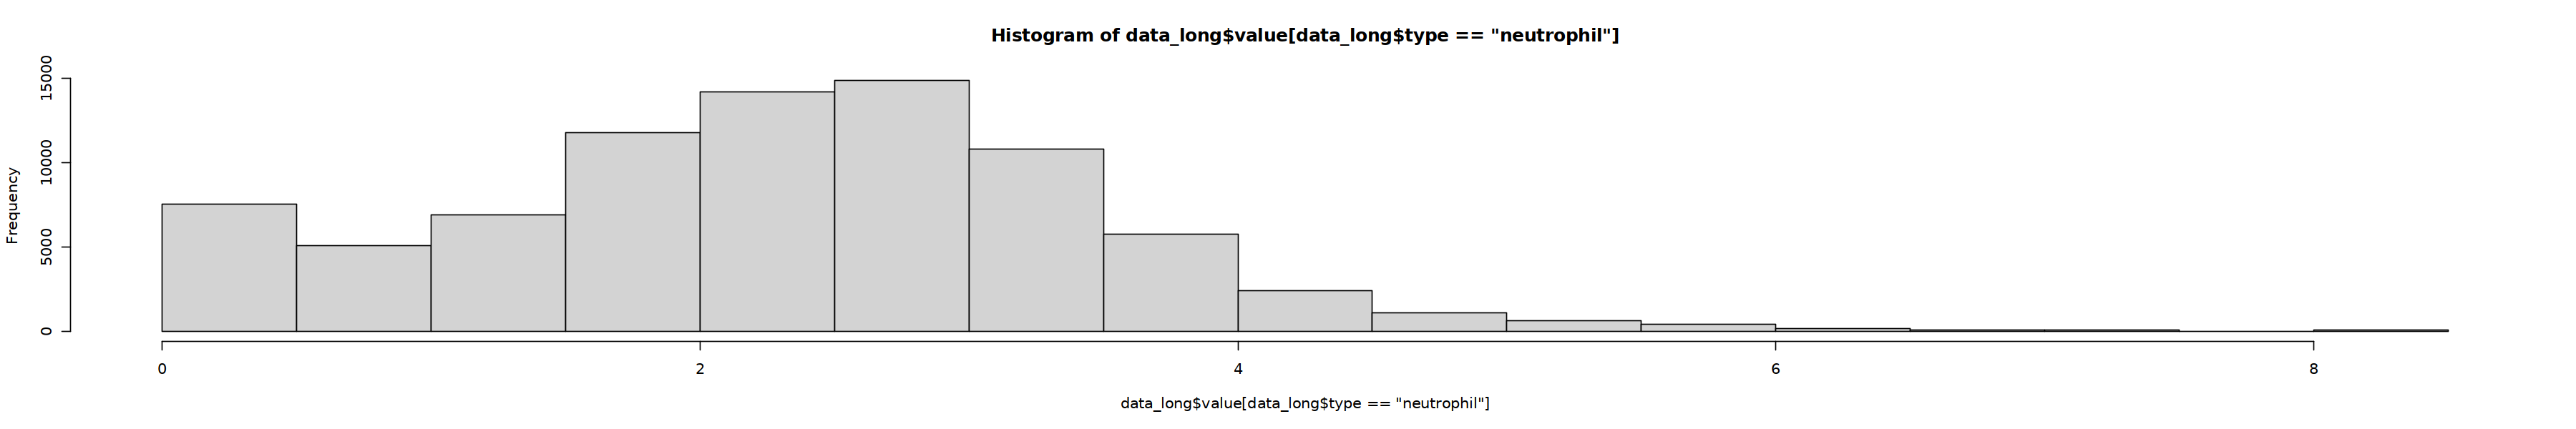

In [120]:
options(repr.plot.width=30, repr.plot.height=5)
hist(data_long$value[data_long$type == 'neutrophil'])

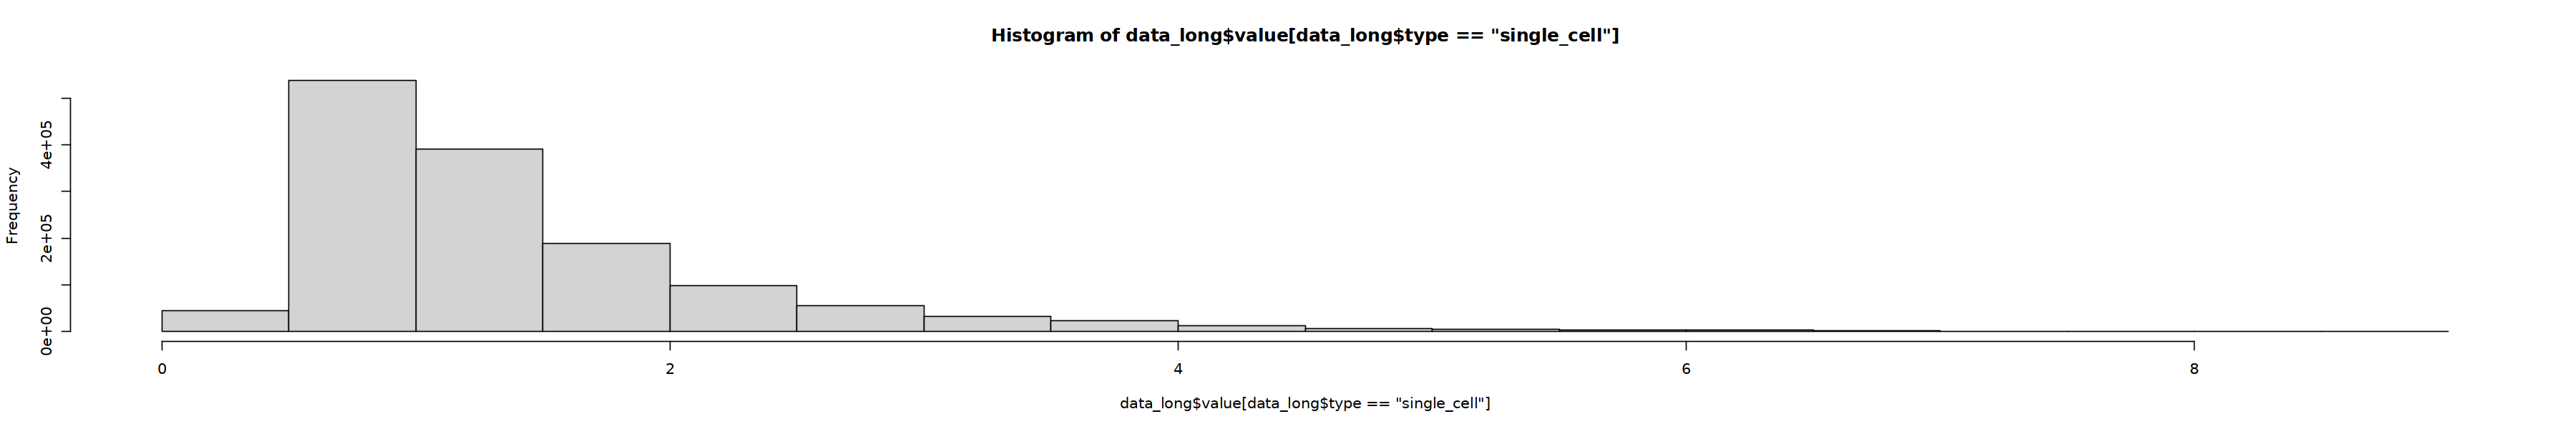

In [121]:
options(repr.plot.width=30, repr.plot.height=5)
hist(data_long$value[data_long$type == 'single_cell'])

In [122]:
### Data Long - comparable expressin values

In [123]:
data_long$value_norm = data_long$value

In [124]:
data_long$value_norm[data_long$type == 'proteomics'] = data_long$value[data_long$type == 'proteomics'] + (min(data_long$value[data_long$type == 'proteomics']) *-1)
# make sure min value is zero

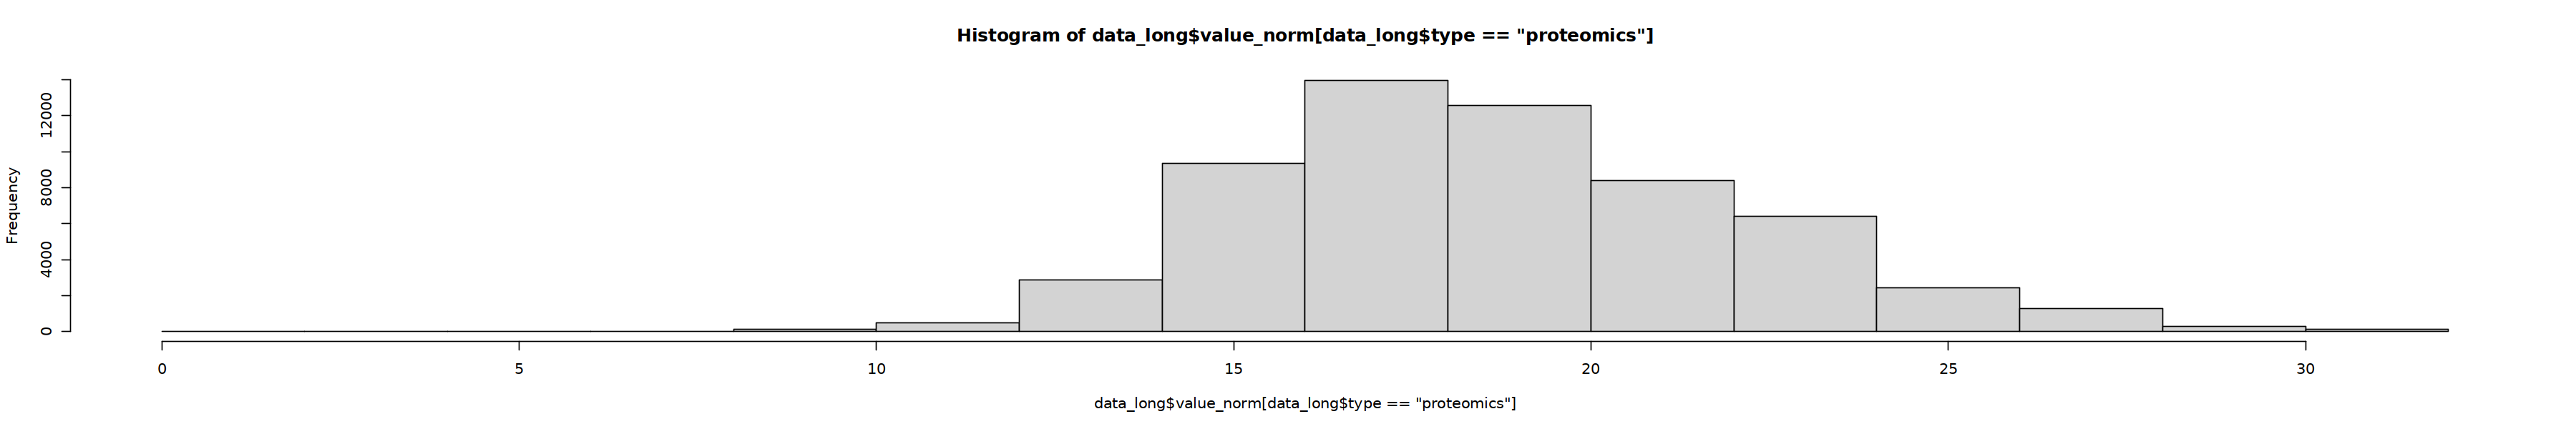

In [125]:
options(repr.plot.width=30, repr.plot.height=5)
hist(data_long$value_norm[data_long$type == 'proteomics'])

In [126]:
adjustments = data_long %>% group_by(type) %>% summarise(adjustment_value = max(value_norm ,na.rm = TRUE) - min(value_norm, na.rm = TRUE))

In [127]:
adjustments

type,adjustment_value
<chr>,<dbl>
clinical_data,16.800000
cytokine,18.018551
neutrophil,8.412481
proteomics,31.211579
single_cell,8.458305


In [128]:
data_long = merge(data_long, adjustments)

In [129]:
data_long$value_norm = data_long$value_norm / data_long$adjustment_value

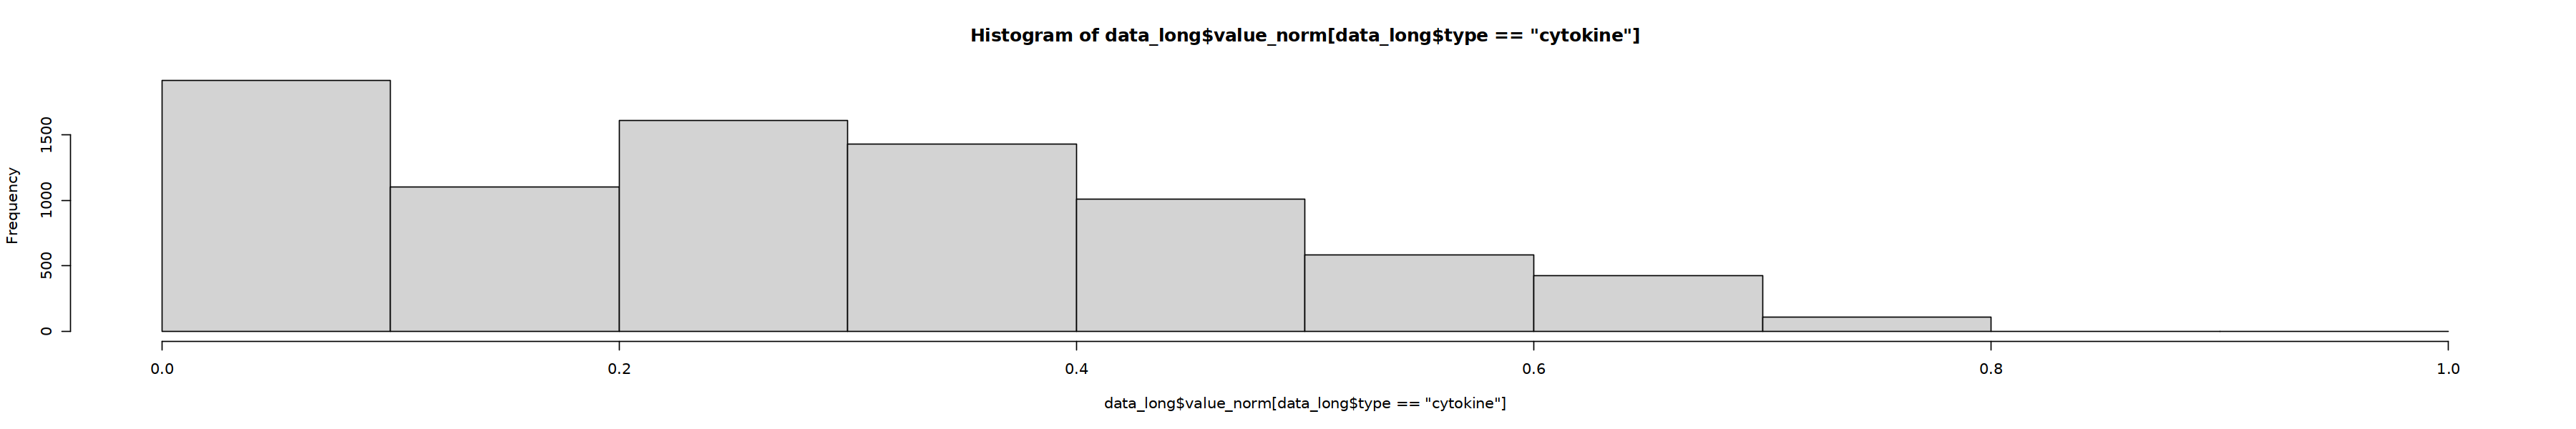

In [130]:
options(repr.plot.width=30, repr.plot.height=5)
hist(data_long$value_norm[data_long$type == 'cytokine'])

In [131]:
head(data_long,2)

,type,variable,X,sample_id,value,config,expression,ident,gene,value_norm,adjustment_value
,<chr>,<chr>,<int>,<chr>,<dbl>,<chr>,<lgl>,<chr>,<chr>,<dbl>,<dbl>
1,clinical_data,CK,1557210,k1,5.459432,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-,TRUE,clinical_data_0_CK,CK,0.3249662,16.8
2,clinical_data,CK,1557211,k10,NA,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-,TRUE,clinical_data_0_CK,CK,NA,16.8


### Data filtered for ligands and receptors

In [132]:
### Filter dataset on ligand and receptor variables

In [133]:
data_long_lig_rec = merge(data_long, ligand_receptor_vars)

In [134]:
# overview amount of ligands and receptors measured per dimension 
unique(data_long_lig_rec[,c('type', 'interaction_type', 'gene')]) %>% group_by(type, interaction_type) %>% count()

type,interaction_type,n
<chr>,<chr>,<int>
cytokine,Ligand,61
neutrophil,Ligand,24
neutrophil,Receptor,43
proteomics,Ligand,53
proteomics,Receptor,19
single_cell,Ligand,53
single_cell,Receptor,75


In [135]:
## generate a variable defining type: cell-type cluster or dimension

In [136]:
data_long_lig_rec$cluster = data_long_lig_rec$type

In [137]:
data_long_lig_rec$cluster[data_long_lig_rec$type == 'single_cell'] = str_replace(data_long_lig_rec$variable[data_long_lig_rec$type == 'single_cell'] , '__.*', '')

In [138]:
unique(data_long_lig_rec$cluster)

[1] "proteomics"                  "neutrophil"                 
 [3] "X6_Monocytes...CD14"         "X4_Monocytes...CD14"        
 [5] "X7_Monocytes...CD14"         "X3_NK"                      
 [7] "X10_B.cell"                  "X0_T.cell.CD4"              
 [9] "X13_Dendritic"               "X1_T.cell.CD8"              
[11] "X11_T.cell.CD4"              "X5_T.cell.CD4"              
[13] "X12_Monocytes...CD16_FCGR3A" "X2_T.cell.CD4"              
[15] "X9_Monocytes...CD16_FCGR3A"  "X8_B.cell"                  
[17] "cytokine"

In [139]:
unique(data_long_lig_rec$type)

[1] "proteomics"  "neutrophil"  "single_cell" "cytokine"

In [140]:
head(data_long_lig_rec,2)

,gene,type,variable,X,sample_id,value,config,expression,ident,value_norm,adjustment_value,interaction_type,cluster
,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,A2M,proteomics,A2M_P01023,1439494,k27,9.138038,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-,TRUE,proteomics_0_A2M_P01023,0.879798,31.21158,Ligand,proteomics
2,A2M,proteomics,A2M_P01023,1439557,k21,9.022400,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-,TRUE,proteomics_0_A2M_P01023,0.876093,31.21158,Ligand,proteomics


### Add information about percentage of cells expressing gene

In [141]:
head(cell_perc_cluster,2)

,X,perc_cells_expressing_gene,total_amount_cells_expressing_gene,gene,cluster
,<chr>,<dbl>,<int>,<chr>,<chr>
1,AL627309.1,0.24327612,18,AL627309.1,8_B-cell
2,AL627309.4,0.05406136,4,AL627309.4,8_B-cell


In [142]:
#cell_perc_cluster[cell_perc_cluster$gene == 'A2M',]

In [143]:
#data_long_lig_rec[(data_long_lig_rec$gene == 'A2M') & (data_long_lig_rec$cluster == 'X1_T.cell.CD8') ,]

In [144]:
cell_perc_cluster$cluster = make.names(cell_perc_cluster$cluster)

In [145]:
nrow(data_long_lig_rec)

[1] 95246

In [146]:
data_long_lig_rec$X = NULL

In [147]:
head(data_long_lig_rec,2)

,gene,type,variable,sample_id,value,config,expression,ident,value_norm,adjustment_value,interaction_type,cluster
,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,A2M,proteomics,A2M_P01023,k27,9.138038,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-,TRUE,proteomics_0_A2M_P01023,0.879798,31.21158,Ligand,proteomics
2,A2M,proteomics,A2M_P01023,k21,9.022400,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-,TRUE,proteomics_0_A2M_P01023,0.876093,31.21158,Ligand,proteomics


In [148]:
unique(data_long_lig_rec$cluster)

[1] "proteomics"                  "neutrophil"                 
 [3] "X6_Monocytes...CD14"         "X4_Monocytes...CD14"        
 [5] "X7_Monocytes...CD14"         "X3_NK"                      
 [7] "X10_B.cell"                  "X0_T.cell.CD4"              
 [9] "X13_Dendritic"               "X1_T.cell.CD8"              
[11] "X11_T.cell.CD4"              "X5_T.cell.CD4"              
[13] "X12_Monocytes...CD16_FCGR3A" "X2_T.cell.CD4"              
[15] "X9_Monocytes...CD16_FCGR3A"  "X8_B.cell"                  
[17] "cytokine"

In [149]:
unique(cell_perc_cluster$cluster)

[1] "X8_B.cell"                   "X9_Monocytes...CD16_FCGR3A" 
 [3] "X5_T.cell.CD4"               "X0_T.cell.CD4"              
 [5] "X1_T.cell.CD8"               "X6_Monocytes...CD14"        
 [7] "X2_T.cell.CD4"               "X4_Monocytes...CD14"        
 [9] "X11_T.cell.CD4"              "X3_NK"                      
[11] "X7_Monocytes...CD14"         "X13_Dendritic"              
[13] "X10_B.cell"                  "X12_Monocytes...CD16_FCGR3A"

In [150]:
data_long_lig_rec = merge(data_long_lig_rec, cell_perc_cluster, all.x = TRUE)

In [151]:
head(data_long_lig_rec,2)

,gene,cluster,type,variable,sample_id,value,config,expression,ident,value_norm,adjustment_value,interaction_type,X,perc_cells_expressing_gene,total_amount_cells_expressing_gene
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>
1,A2M,proteomics,proteomics,A2M_P01023,k27,9.138038,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-,TRUE,proteomics_0_A2M_P01023,0.879798,31.21158,Ligand,NA,NA,NA
2,A2M,proteomics,proteomics,A2M_P01023,k21,9.022400,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-,TRUE,proteomics_0_A2M_P01023,0.876093,31.21158,Ligand,NA,NA,NA


In [152]:
# NA values for percentage of cells expressing genes for non-sc dimensions
unique(data_long_lig_rec$type[is.na(data_long_lig_rec$perc_cells_expressing_gene)])  # check whether matching succeeded

[1] "proteomics" "neutrophil" "cytokine"

In [153]:
# TBD: potential replacement for percentage cells expressing gene value for other dimensions
data_long_lig_rec$perc_cells_expressing_gene[is.na(data_long_lig_rec$perc_cells_expressing_gene)] = mean(data_long_lig_rec$perc_cells_expressing_gene, na.rm = TRUE)

In [154]:
unique(data_long_lig_rec$type)

[1] "proteomics"  "neutrophil"  "single_cell" "cytokine"

### Aggregate across samples (mean expression etc.)

In [155]:
### Investigate relationship mean expresison per sample - perc_cells_expressing gene etc. 

In [156]:
### Calculate variance and mean expression per cell-type across samples for single cell data

analyze_expr_cluster = data_long_lig_rec %>% group_by(type, interaction_type, gene, cluster, perc_cells_expressing_gene, total_amount_cells_expressing_gene, ident) %>% summarise(mean_expr_norm = mean(value_norm, na.rm = TRUE),mean_expr = mean(value, na.rm = TRUE), var_expression = var(value, na.rm = TRUE))

`summarise()` has grouped output by 'type', 'interaction_type', 'gene',
'cluster', 'perc_cells_expressing_gene', 'total_amount_cells_expressing_gene'.
You can override using the `.groups` argument.


In [157]:
### Generate cell type columns
analyze_expr_cluster$cell_type = str_replace(analyze_expr_cluster$cluster, 'X.*_', '')

In [158]:
head(analyze_expr_cluster,2)

type,interaction_type,gene,cluster,perc_cells_expressing_gene,total_amount_cells_expressing_gene,ident,mean_expr_norm,mean_expr,var_expression,cell_type
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
cytokine,Ligand,CCL1,cytokine,69.10381,NA,cytokine_0_I309__CCL1,0.08087945,1.457331,0.4209982,cytokine
cytokine,Ligand,CCL11,cytokine,69.10381,NA,cytokine_0_Eotaxin__CCL11,0.41114433,7.408225,3.1654144,cytokine


In [159]:
unique(analyze_expr_cluster$cell_type)

[1] "cytokine"         "neutrophil"       "proteomics"       "Monocytes...CD14"
 [5] "T.cell.CD4"       "T.cell.CD8"       "B.cell"           "FCGR3A"          
 [9] "Dendritic"        "NK"

### Cluster similar receptors and ligand (expressed in same cell-types)

In [160]:
### Receptors

In [161]:
filter_type_vis = c('cytokine', 'proteomics', 'neutrophil')

In [162]:
cluster_data = analyze_expr_cluster[(analyze_expr_cluster$interaction_type == 'Receptor') & (!analyze_expr_cluster$type %in% filter_type_vis),] %>% dcast(gene ~ cluster, value.var = 'mean_expr')

In [163]:
cluster_data[is.na(cluster_data)] = 0

In [164]:
rownames(cluster_data) = cluster_data$gene

In [165]:
cluster_data$gene = NULL

In [166]:
head(cluster_data,2)

,X0_T.cell.CD4,X1_T.cell.CD8,X10_B.cell,X11_T.cell.CD4,X12_Monocytes...CD16_FCGR3A,X13_Dendritic,X2_T.cell.CD4,X3_NK,X4_Monocytes...CD14,X5_T.cell.CD4,X6_Monocytes...CD14,X7_Monocytes...CD14,X8_B.cell,X9_Monocytes...CD16_FCGR3A
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AGTRAP,0,0,0,0,0,0,0,0,1.2045378,0,1.158767,1.183921,0,0
ANXA6,0,0,0,0,0,0,0,0,0.7138537,0,0.000000,0.000000,0,0


In [167]:
cluster_result = kmeans(cluster_data, centers = 7, iter.max = 10, nstart = 1)

In [168]:
cluster_result = data.frame(cluster= cluster_result$cluster, gene = names(cluster_result$cluster))

In [169]:
cluster_result$interaction_type = 'Receptor'

In [170]:
head(cluster_result,2)

,cluster,gene,interaction_type
,<int>,<chr>,<chr>
AGTRAP,2,AGTRAP,Receptor
ANXA6,3,ANXA6,Receptor


In [171]:
### Ligands

In [172]:
cluster_data = analyze_expr_cluster[analyze_expr_cluster$interaction_type == 'Ligand' & (!analyze_expr_cluster$type %in% filter_type_vis),] %>% dcast(gene ~ cluster, value.var = 'mean_expr')

In [173]:
cluster_data[is.na(cluster_data)] = 0

In [174]:
rownames(cluster_data) = cluster_data$gene

In [175]:
cluster_data$gene = NULL

In [176]:
head(cluster_data,2)

,X0_T.cell.CD4,X1_T.cell.CD8,X10_B.cell,X11_T.cell.CD4,X12_Monocytes...CD16_FCGR3A,X13_Dendritic,X2_T.cell.CD4,X3_NK,X4_Monocytes...CD14,X5_T.cell.CD4,X6_Monocytes...CD14,X7_Monocytes...CD14,X8_B.cell,X9_Monocytes...CD16_FCGR3A
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ADAM17,0,0,0,0,0,0,0,0,0.8383966,0,0.8149382,0,0,0
AIMP1,0,0,0,0,0,0,0,0,0.7533036,0,0.0000000,0,0,0


In [177]:
cluster_result_l = kmeans(cluster_data, centers = 10, iter.max = 10, nstart = 1)

In [178]:
cluster_result_l = data.frame(cluster= cluster_result_l$cluster, gene = names(cluster_result_l$cluster))

In [179]:
cluster_result_l$interaction_type = 'Ligand'

In [180]:
head(cluster_result_l,2)

,cluster,gene,interaction_type
,<int>,<chr>,<chr>
ADAM17,5,ADAM17,Ligand
AIMP1,5,AIMP1,Ligand


In [181]:
### Merge both

In [182]:
cluster_result = rbind(cluster_result, cluster_result_l)

In [183]:
colnames(cluster_result) = c('cluster_vis', 'gene', 'interaction_type')

In [184]:
#### Visualize

In [185]:
nrow(analyze_expr_cluster)

[1] 812

In [186]:
nrow(merge(analyze_expr_cluster, cluster_result))

[1] 661

In [187]:
analyze_expr_cluster = merge(analyze_expr_cluster, cluster_result, all.x = TRUE)

In [188]:
head(analyze_expr_cluster,2)

,interaction_type,gene,type,cluster,perc_cells_expressing_gene,total_amount_cells_expressing_gene,ident,mean_expr_norm,mean_expr,var_expression,cell_type,cluster_vis
,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,Ligand,A2M,proteomics,proteomics,69.10381,NA,proteomics_0_A2M_P01023,0.86719027,8.7445302,0.32468578,proteomics,NA
2,Ligand,ADAM17,single_cell,X4_Monocytes...CD14,49.68889,7267,single_cell_0_X4_Monocytes...CD14__ADAM17,0.09912111,0.8383966,0.03136488,Monocytes...CD14,5


In [189]:
write.table(analyze_expr_cluster,gzfile(paste0(result_path, '/F-Analysis/' ,'F4_Ligand_Receptor_Data_Expression', name, filter_samples,  '.gz')))

# Ligand Receptor Data

## Calculate ligand receptor Correlations

In [190]:
head(data_long_lig_rec,2)

,gene,cluster,type,variable,sample_id,value,config,expression,ident,value_norm,adjustment_value,interaction_type,X,perc_cells_expressing_gene,total_amount_cells_expressing_gene
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>
1,A2M,proteomics,proteomics,A2M_P01023,k27,9.138038,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-,TRUE,proteomics_0_A2M_P01023,0.879798,31.21158,Ligand,NA,69.10381,NA
2,A2M,proteomics,proteomics,A2M_P01023,k21,9.022400,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-,TRUE,proteomics_0_A2M_P01023,0.876093,31.21158,Ligand,NA,69.10381,NA


In [191]:
### Transform to wide format

In [192]:
ligand_receptor_expression = data_long_lig_rec %>% dcast(sample_id ~ ident, value.var = 'value')

In [193]:
rownames(ligand_receptor_expression) = ligand_receptor_expression$sample_id

In [194]:
ligand_receptor_expression$sample_id = NULL

In [195]:
head(ligand_receptor_expression,2)

,cytokine_0_BCA1__CXCL13,cytokine_0_CTACK__CCL27,cytokine_0_EGF__EGF,cytokine_0_ENA78__CXCL5,cytokine_0_Eotaxin__CCL11,cytokine_0_Eotaxin2__CCL24,cytokine_0_Eotaxin3__CCL26,cytokine_0_FGF2__FGF2,cytokine_0_FLT3L__FLT3LG,cytokine_0_Fractalkine__CX3CL1,⋯,single_cell_0_X9_Monocytes...CD16_FCGR3A__RTN4,single_cell_0_X9_Monocytes...CD16_FCGR3A__SELPLG,single_cell_0_X9_Monocytes...CD16_FCGR3A__SERPINA1,single_cell_0_X9_Monocytes...CD16_FCGR3A__SPN,single_cell_0_X9_Monocytes...CD16_FCGR3A__TGFB1,single_cell_0_X9_Monocytes...CD16_FCGR3A__TIMP1,single_cell_0_X9_Monocytes...CD16_FCGR3A__TNFRSF14,single_cell_0_X9_Monocytes...CD16_FCGR3A__TNFRSF1B,single_cell_0_X9_Monocytes...CD16_FCGR3A__TNFSF10,single_cell_0_X9_Monocytes...CD16_FCGR3A__TNFSF13B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
k1,5.696550,9.821662,5.045268,10.562366,7.42341,8.755388,8.820594,6.734845,5.200065,7.552054,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
k10,4.697663,9.701220,1.922198,7.724173,9.19842,9.728363,5.598127,5.791293,3.737687,5.874305,⋯,1.343136,0.6540153,2.677473,1.21784,0.8279207,2.885468,0.8118693,2.711,1.428577,1.190677


In [196]:
### Deinfe Ligands and Receptors

In [197]:
ligands = unique(data_long_lig_rec$ident[data_long_lig_rec$interaction_type == 'Ligand'])

In [198]:
length(ligands)

[1] 445

In [199]:
receptors = unique(data_long_lig_rec$ident[data_long_lig_rec$interaction_type == 'Receptor'])

In [200]:
length(receptors)

[1] 367

In [201]:
ncol(ligand_receptor_expression)

[1] 812

In [202]:
#### Calculate correlations

In [203]:
ligand_receptor_correlations = cor(ligand_receptor_expression[,colnames(ligand_receptor_expression) %in%ligands], ligand_receptor_expression[,colnames(ligand_receptor_expression) %in% receptors], method = 'spearman', use = 'pairwise.complete.obs')
# currently calculated with spearman!

In [204]:
#### Adjust format of calculated correlations

In [205]:
ligand_receptor_correlations = melt(ligand_receptor_correlations)

In [206]:
colnames(ligand_receptor_correlations) = c('ligand', 'receptor', 'correlation')

In [207]:
head(ligand_receptor_correlations,2)

,ligand,receptor,correlation
,<fct>,<fct>,<dbl>
1,cytokine_0_BCA1__CXCL13,neutrophil_0_ABCA7,0.09543501
2,cytokine_0_CTACK__CCL27,neutrophil_0_ABCA7,0.05916357


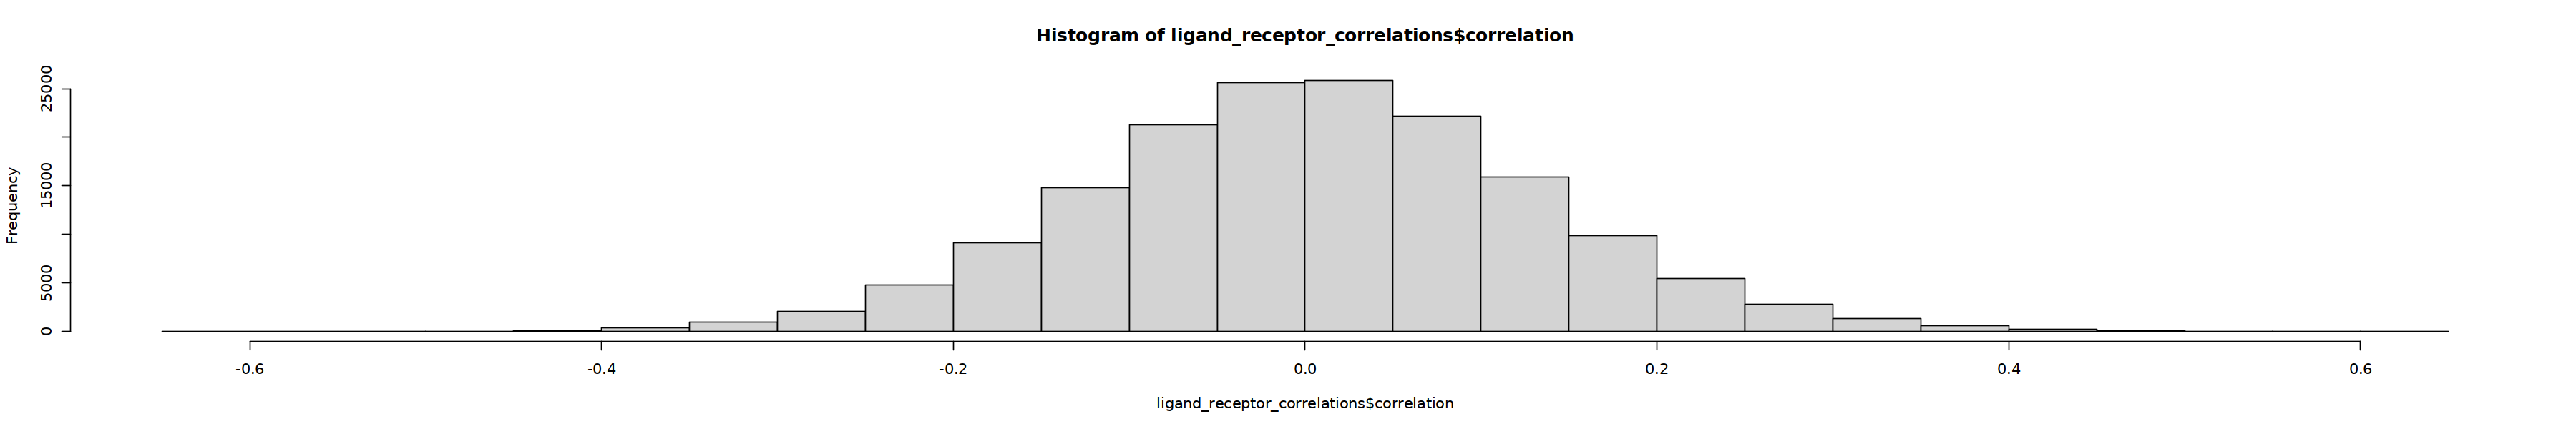

In [208]:
### Distribution of calculated correlations
options(repr.plot.width=30, repr.plot.height=5)
hist(ligand_receptor_correlations$correlation)

## Add nichenet interaction potential

In [209]:
head(ligand_receptor_interactions,2)

Ligand,Receptor,amount_sources
<chr>,<chr>,<int>
A2M,LRP1,1
A2M,TNFRSF14,1


In [210]:
head(weighted_networks$lr_sig,2)

from,to,weight
<chr>,<chr>,<dbl>
A1BG,ABCC6,0.4216439
A1BG,ACE2,0.1007411


In [211]:
ligand_receptor_interactions =merge( ligand_receptor_interactions, weighted_networks$lr_sig, by.x = c('Ligand', 'Receptor'), by.y = c('from','to'))

In [212]:
nrow(ligand_receptor_interactions)

[1] 11639

In [213]:
head(ligand_receptor_interactions,2)

,Ligand,Receptor,amount_sources,weight
,<chr>,<chr>,<int>,<dbl>
1,A2M,LRP1,1,0.4678977
2,A2M,TNFRSF14,1,0.6990671


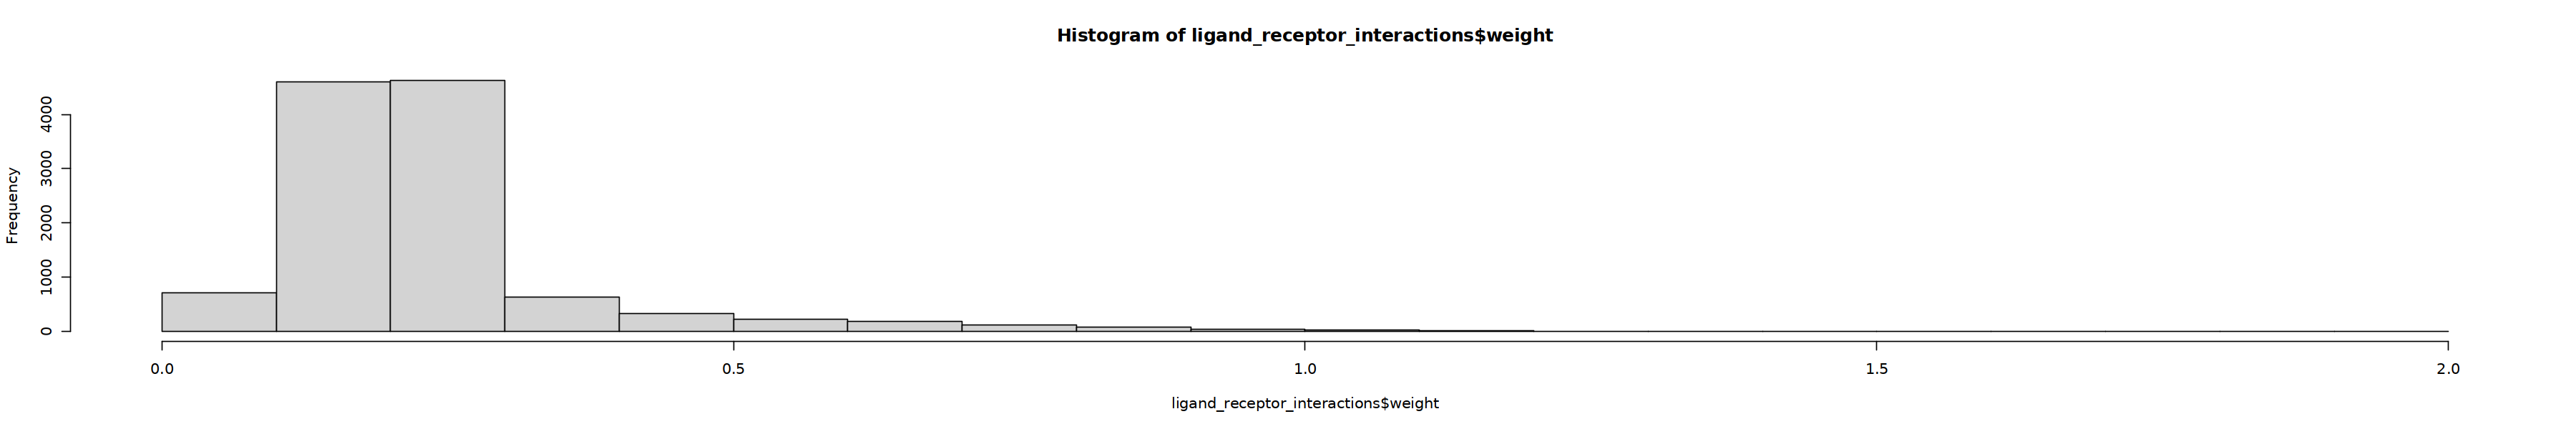

In [214]:
hist(ligand_receptor_interactions$weight)

In [215]:
#### Add expression data

In [216]:
unique(analyze_expr_cluster$type)

[1] "proteomics"  "single_cell" "neutrophil"  "cytokine"

In [217]:
head(analyze_expr_cluster,2)

,interaction_type,gene,type,cluster,perc_cells_expressing_gene,total_amount_cells_expressing_gene,ident,mean_expr_norm,mean_expr,var_expression,cell_type,cluster_vis
,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,Ligand,A2M,proteomics,proteomics,69.10381,NA,proteomics_0_A2M_P01023,0.86719027,8.7445302,0.32468578,proteomics,NA
2,Ligand,ADAM17,single_cell,X4_Monocytes...CD14,49.68889,7267,single_cell_0_X4_Monocytes...CD14__ADAM17,0.09912111,0.8383966,0.03136488,Monocytes...CD14,5


In [218]:
analyze_expr_cluster$variable = paste0(analyze_expr_cluster$cluster, '_0_', analyze_expr_cluster$gene)

In [219]:
nrow(ligand_receptor_interactions)

[1] 11639

In [220]:
#### Add data for ligands
data  = merge(ligand_receptor_interactions, analyze_expr_cluster[analyze_expr_cluster$interaction_type == 'Ligand',], by.x = c('Ligand'), by.y = c('gene'),  suffixes = c("","_L"))

In [221]:
#### Add data for Receptors
data  = merge(data, analyze_expr_cluster[analyze_expr_cluster$interaction_type == 'Receptor',], by.x = c('Receptor'), by.y = c('gene'),  suffixes = c("","_R"))

In [222]:
head(data,2)

,Receptor,Ligand,amount_sources,weight,interaction_type,type,cluster,perc_cells_expressing_gene,total_amount_cells_expressing_gene,ident,⋯,cluster_R,perc_cells_expressing_gene_R,total_amount_cells_expressing_gene_R,ident_R,mean_expr_norm_R,mean_expr_R,var_expression_R,cell_type_R,cluster_vis_R,variable_R
,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,⋯,<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>
1,ABCA7,APOA1,1,0.4572367,Ligand,proteomics,proteomics,69.10381,NA,proteomics_0_APOA1_P02647,⋯,neutrophil,69.10381,NA,neutrophil_0_ABCA7,0.1649437,1.387586,0.8848451,neutrophil,NA,neutrophil_0_ABCA7
2,ADIPOR1,ADIPOQ,1,0.7307022,Ligand,proteomics,proteomics,69.10381,NA,proteomics_0_ADIPOQ_Q15848,⋯,neutrophil,69.10381,NA,neutrophil_0_ADIPOR1,0.2697883,2.269589,0.8178776,neutrophil,NA,neutrophil_0_ADIPOR1


In [223]:
colnames(data)

[1] "Receptor"                            
 [2] "Ligand"                              
 [3] "amount_sources"                      
 [4] "weight"                              
 [5] "interaction_type"                    
 [6] "type"                                
 [7] "cluster"                             
 [8] "perc_cells_expressing_gene"          
 [9] "total_amount_cells_expressing_gene"  
[10] "ident"                               
[11] "mean_expr_norm"                      
[12] "mean_expr"                           
[13] "var_expression"                      
[14] "cell_type"                           
[15] "cluster_vis"                         
[16] "variable"                            
[17] "interaction_type_R"                  
[18] "type_R"                              
[19] "cluster_R"                           
[20] "perc_cells_expressing_gene_R"        
[21] "total_amount_cells_expressing_gene_R"
[22] "ident_R"                             
[23] "mean_expr_norm_R"                    
[24] "mean_expr_R"                         
[25] "var_expression_R"                    
[26] "cell_type_R"                         
[27] "cluster_vis_R"                       
[28] "variable_R"

In [224]:
nrow(data)

[1] 5835

In [225]:
unique(data$type)

[1] "proteomics"  "single_cell" "neutrophil"  "cytokine"

In [226]:
#### Remove same type links

In [227]:
data = data[data$cell_type != data$cell_type_R,]

In [228]:
nrow(data)

[1] 4930

In [229]:
filter_type_vis

[1] "cytokine"   "proteomics" "neutrophil"

In [230]:
unique(data$type)

[1] "proteomics"  "single_cell" "neutrophil"  "cytokine"

## Combine expression data with correlations

In [231]:
head(ligand_receptor_correlations,2)

,ligand,receptor,correlation
,<fct>,<fct>,<dbl>
1,cytokine_0_BCA1__CXCL13,neutrophil_0_ABCA7,0.09543501
2,cytokine_0_CTACK__CCL27,neutrophil_0_ABCA7,0.05916357


In [232]:
head(data,2)

,Receptor,Ligand,amount_sources,weight,interaction_type,type,cluster,perc_cells_expressing_gene,total_amount_cells_expressing_gene,ident,⋯,cluster_R,perc_cells_expressing_gene_R,total_amount_cells_expressing_gene_R,ident_R,mean_expr_norm_R,mean_expr_R,var_expression_R,cell_type_R,cluster_vis_R,variable_R
,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,⋯,<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>
1,ABCA7,APOA1,1,0.4572367,Ligand,proteomics,proteomics,69.10381,NA,proteomics_0_APOA1_P02647,⋯,neutrophil,69.10381,NA,neutrophil_0_ABCA7,0.1649437,1.387586,0.8848451,neutrophil,NA,neutrophil_0_ABCA7
2,ADIPOR1,ADIPOQ,1,0.7307022,Ligand,proteomics,proteomics,69.10381,NA,proteomics_0_ADIPOQ_Q15848,⋯,neutrophil,69.10381,NA,neutrophil_0_ADIPOR1,0.2697883,2.269589,0.8178776,neutrophil,NA,neutrophil_0_ADIPOR1


In [233]:
nrow(data)

[1] 4930

In [234]:
nrow(ligand_receptor_correlations)

[1] 163315

In [235]:
data = merge(data, ligand_receptor_correlations, by.x = c('ident', 'ident_R'), by.y = c('ligand', 'receptor'))

In [236]:
nrow(data)

[1] 4930

In [237]:
filter_samples

[1] "all"

In [238]:
write.table(data,gzfile(paste0(result_path, '/F-Analysis/' ,'F4_Ligand_Receptor_Data', name, filter_samples,'.gz')))

## Define expressed ligands and potential ligand - target combinations based on expressed receptors

In [239]:
### Define minimum amount of expression of receptor in receiving cell to be able to react to ligand

In [240]:
head(ligand_receptor_interactions,2)

,Ligand,Receptor,amount_sources,weight
,<chr>,<chr>,<int>,<dbl>
1,A2M,LRP1,1,0.4678977
2,A2M,TNFRSF14,1,0.6990671


In [241]:
head(cell_perc_cluster,2)

,X,perc_cells_expressing_gene,total_amount_cells_expressing_gene,gene,cluster
,<chr>,<dbl>,<int>,<chr>,<chr>
1,AL627309.1,0.24327612,18,AL627309.1,X8_B.cell
2,AL627309.4,0.05406136,4,AL627309.4,X8_B.cell


In [242]:
### Set threshold to filter out receptors that are to low expressed
cell_perc_cluster_filtered =  cell_perc_cluster[((cell_perc_cluster$perc_cells > 30) & (cell_perc_cluster$total_amount_cells_expressing_gene > 600)) | ((cell_perc_cluster$perc_cells > 10) & (cell_perc_cluster$total_amount_cells_expressing_gene > 1200)),]

# currently quite strict threshold for receptors?

In [243]:
potential_ligand_target_types_comb = merge(ligand_receptor_interactions, cell_perc_cluster_filtered, by.x = 'Receptor', by.y = 'gene')

In [244]:
head(potential_ligand_target_types_comb,2)

,Receptor,Ligand,amount_sources,weight,X,perc_cells_expressing_gene,total_amount_cells_expressing_gene,cluster
,<chr>,<chr>,<int>,<dbl>,<chr>,<dbl>,<int>,<chr>
1,ABCA1,APOA1,1,0.8194814,ABCA19,15.74701,2303,X4_Monocytes...CD14
2,ABCA1,APOA1,1,0.8194814,ABCA17,16.46135,1844,X6_Monocytes...CD14


In [245]:
potential_ligand_target_types_comb = unique(potential_ligand_target_types_comb[,c('Ligand', 'cluster')] )

In [246]:
colnames(potential_ligand_target_types_comb) = c('Ligand', 'cluster_R')

In [247]:
head(potential_ligand_target_types_comb,2)

,Ligand,cluster_R
,<chr>,<chr>
1,APOA1,X4_Monocytes...CD14
2,APOA1,X6_Monocytes...CD14


In [248]:
unique(potential_ligand_target_types_comb$cluster_R)

[1] "X4_Monocytes...CD14"         "X6_Monocytes...CD14"        
 [3] "X2_T.cell.CD4"               "X1_T.cell.CD8"              
 [5] "X7_Monocytes...CD14"         "X0_T.cell.CD4"              
 [7] "X12_Monocytes...CD16_FCGR3A" "X3_NK"                      
 [9] "X9_Monocytes...CD16_FCGR3A"  "X8_B.cell"                  
[11] "X11_T.cell.CD4"              "X10_B.cell"                 
[13] "X5_T.cell.CD4"               "X13_Dendritic"

In [249]:
# Below: ligands where receptors are only expressed in very low amount of targets 
unique(potential_ligand_target_types_comb[,c('Ligand', 'cluster_R')]) %>% group_by(Ligand) %>% count() %>% filter(n == 1)


Ligand,n
<chr>,<int>
ARTN,1
CNTN2,1
DEFB4A,1
DEFB4B,1
DHH,1
FLT3LG,1
GPHA2,1
IHH,1
IL18,1


In [250]:
expressed_ligand_types = unique(data[,c('Ligand', 'cluster', 'mean_expr', 'type', 'variable', 'ident')])

# Ligand Target Data

## Calculate ligand - target correlations

In [251]:
head(expressed_ligand_types,2)

,Ligand,cluster,mean_expr,type,variable,ident
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
1,CXCL13,cytokine,5.429313,cytokine,cytokine_0_CXCL13,cytokine_0_BCA1__CXCL13
30,CCL27,cytokine,9.723839,cytokine,cytokine_0_CCL27,cytokine_0_CTACK__CCL27


In [252]:
#### generate variable column for single-cell
expressed_ligand_types$variable[expressed_ligand_types$type == 'single_cell'] = paste0(expressed_ligand_types$type[expressed_ligand_types$type == 'single_cell'], '_0_',expressed_ligand_types$cluster[expressed_ligand_types$type == 'single_cell'], '__', expressed_ligand_types$Ligand[expressed_ligand_types$type == 'single_cell'] )

In [253]:
expressed_ligands = unique(expressed_ligand_types$ident)

In [254]:
length(expressed_ligands)

[1] 344

In [255]:
### Transform data_long to matrix format

In [256]:
head(data_long,2)

,type,variable,X,sample_id,value,config,expression,ident,gene,value_norm,adjustment_value
,<chr>,<chr>,<int>,<chr>,<dbl>,<chr>,<lgl>,<chr>,<chr>,<dbl>,<dbl>
1,clinical_data,CK,1557210,k1,5.459432,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-,TRUE,clinical_data_0_CK,CK,0.3249662,16.8
2,clinical_data,CK,1557211,k10,NA,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-,TRUE,clinical_data_0_CK,CK,NA,16.8


In [257]:
expression_data = data_long %>% dcast(sample_id ~ ident, value.var = 'value')

In [258]:
rownames(expression_data) = expression_data$sample_id

In [259]:
expression_data$sample_id = NULL

In [260]:
head(expression_data,2)

,clinical_data_0_CK,clinical_data_0_CK_MB,clinical_data_0_CRP,clinical_data_0_delta_ef_value,clinical_data_0_Troponin,cytokine_0_BCA1__CXCL13,cytokine_0_CTACK__CCL27,cytokine_0_EGF__EGF,cytokine_0_ENA78__CXCL5,cytokine_0_Eotaxin__CCL11,⋯,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZEB2,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFAND5,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFAS1,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFP36,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFP36L1,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFP36L2,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZNF106,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZNF207,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZNF706,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZYX
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
k1,5.459432,NA,0.4854268,NA,0.01863417,5.696550,9.821662,5.045268,10.562366,7.42341,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
k10,NA,NA,0.2630344,NA,NA,4.697663,9.701220,1.922198,7.724173,9.19842,⋯,2.461054,2.157169,1.975326,3.139595,2.078417,1.843355,1.343136,0.6540153,1.190677,0.8572279


In [261]:
### Validate correlation result
cor(x = expression_data$clinical_data_0_CK_MB,y= expression_data$cytokine_0_IL1beta__IL1B, method = 'spearman', use = 'pairwise.complete.obs')

[1] 0.1554351

In [262]:
### Check whether all ligands can be matched to the features in expression data 
dim(expression_data[,colnames(expression_data) %in% expressed_ligands])

[1] 146 344

In [263]:
### Inspect certain examples

In [264]:
### Calculate all correlations

In [265]:
head(expression_data,2)

,clinical_data_0_CK,clinical_data_0_CK_MB,clinical_data_0_CRP,clinical_data_0_delta_ef_value,clinical_data_0_Troponin,cytokine_0_BCA1__CXCL13,cytokine_0_CTACK__CCL27,cytokine_0_EGF__EGF,cytokine_0_ENA78__CXCL5,cytokine_0_Eotaxin__CCL11,⋯,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZEB2,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFAND5,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFAS1,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFP36,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFP36L1,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFP36L2,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZNF106,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZNF207,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZNF706,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZYX
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
k1,5.459432,NA,0.4854268,NA,0.01863417,5.696550,9.821662,5.045268,10.562366,7.42341,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
k10,NA,NA,0.2630344,NA,NA,4.697663,9.701220,1.922198,7.724173,9.19842,⋯,2.461054,2.157169,1.975326,3.139595,2.078417,1.843355,1.343136,0.6540153,1.190677,0.8572279


In [266]:
nrow(expression_data)

[1] 146

In [267]:
rowSums(!is.na(expression_data))[rowSums(!is.na(expression_data)) == 0]

m1.2  m1.3  m1.4 m12.3 m12.4 m16.3 m16.4 m17.2 m17.3 m17.4 
    0     0     0     0     0     0     0     0     0     0

In [268]:
ligand_target_correlations = cor(expression_data[,colnames(expression_data) %in% expressed_ligands], expression_data[,!colnames(expression_data) %in% expressed_ligands], method = 'spearman', use = 'pairwise.complete.obs') 

Warning message in stats::cor(x, y, use, method):
“the standard deviation is zero”
Warning message in stats::cor(x, y, use, method):
“the standard deviation is zero”
Warning message in stats::cor(x, y, use, method):
“the standard deviation is zero”
Warning message in stats::cor(x, y, use, method):
“the standard deviation is zero”
Warning message in stats::cor(x, y, use, method):
“the standard deviation is zero”
Warning message in stats::cor(x, y, use, method):
“the standard deviation is zero”
Warning message in stats::cor(x, y, use, method):
“the standard deviation is zero”
Warning message in stats::cor(x, y, use, method):
“the standard deviation is zero”
Warning message in stats::cor(x, y, use, method):
“the standard deviation is zero”
Warning message in stats::cor(x, y, use, method):
“the standard deviation is zero”
Warning message in stats::cor(x, y, use, method):
“the standard deviation is zero”
Warning message in stats::cor(x, y, use, method):
“the standard deviation is zero”
Warn

In [269]:
#head(expression_data[,!is.na(str_extract(colnames(expression_data), 'ZFP36L2'))])

In [270]:
head(ligand_target_correlations,2)

,clinical_data_0_CK,clinical_data_0_CK_MB,clinical_data_0_CRP,clinical_data_0_delta_ef_value,clinical_data_0_Troponin,cytokine_0_Eotaxin__CCL11,cytokine_0_Eotaxin2__CCL24,cytokine_0_FLT3L__FLT3LG,cytokine_0_GROalpha__CXCL1,cytokine_0_IL12p40__IL12B,⋯,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZEB2,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFAND5,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFAS1,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFP36,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFP36L1,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFP36L2,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZNF106,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZNF207,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZNF706,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZYX
cytokine_0_BCA1__CXCL13,0.04568048,0.1841583,0.03474096,-0.263390374,0.08664079,-0.4042097,0.07479910,-0.12506712,-0.20342629,-0.06320019,⋯,0.14780538,0.06469496,-0.033172594,0.02807027,0.006225096,0.08782851,-0.06057393,0.1023231,0.20825309,-0.02657856
cytokine_0_CTACK__CCL27,-0.19761446,-0.3175698,0.01813627,-0.008483006,-0.09251747,0.1002265,0.07672164,-0.02487356,-0.03717696,0.30506995,⋯,-0.02130075,-0.15482846,0.004267636,-0.11350619,-0.029636124,-0.04159127,0.08755046,-0.1470658,-0.01133356,-0.05600466


In [271]:
ligand_target_correlations_backup = ligand_target_correlations

In [272]:
ligand_target_correlations = ligand_target_correlations_backup

In [273]:
### Transform to long format

In [274]:
ligand_target_correlations = melt(ligand_target_correlations)

In [275]:
colnames(ligand_target_correlations) = c('Ligand', 'Target', 'correlation')

In [276]:
### Adjust and extract certain columns

In [277]:
#length(unique(ligand_target_correlations$Ligand))

In [278]:
ligand_target_correlations$Target_Gene = str_replace(ligand_target_correlations$Target, '.*_0_', '')

In [279]:
ligand_target_correlations$Target_Gene = str_replace(ligand_target_correlations$Target_Gene, '.*__', '')

In [280]:
ligand_target_correlations$Ligand_Gene = str_replace(ligand_target_correlations$Ligand, '.*_0_', '')

In [281]:
ligand_target_correlations$Ligand_Gene = str_replace(ligand_target_correlations$Ligand_Gene, '.*__', '')

In [282]:
ligand_target_correlations$Target_Type = str_replace(ligand_target_correlations$Target, '_0_.*', '')

In [283]:
ligand_target_correlations$Target_Type[ligand_target_correlations$Target_Type == 'single_cell']  = str_replace(ligand_target_correlations$Target[ligand_target_correlations$Target_Type == 'single_cell'] , '__.*', '')

In [284]:
###  Adapt target gene for proteomics
ligand_target_correlations$Target_Gene[ligand_target_correlations$Target_Type == 'proteomics'] = str_replace(ligand_target_correlations$Target_Gene[ligand_target_correlations$Target_Type == 'proteomics'], '_.*', '')
ligand_target_correlations$Ligand_Gene[ligand_target_correlations$Ligand_Type == 'proteomics'] = str_replace(ligand_target_correlations$Ligand_Gene[ligand_target_correlations$Ligand_Type == 'proteomics'], '_.*', '')

In [285]:
ligand_target_correlations$Ligand_Type = str_replace(ligand_target_correlations$Ligand, '_0_.*', '')

In [286]:
ligand_target_correlations$Ligand_Type[ligand_target_correlations$Ligand_Type == 'single_cell']  = str_replace(ligand_target_correlations$Ligand[ligand_target_correlations$Ligand_Type == 'single_cell'] , '__.*', '')

In [287]:
head(sort(unique(ligand_target_correlations$Ligand)))

[1] cytokine_0_BCA1__CXCL13    cytokine_0_CTACK__CCL27   
[3] cytokine_0_EGF__EGF        cytokine_0_ENA78__CXCL5   
[5] cytokine_0_Eotaxin3__CCL26 cytokine_0_FGF2__FGF2     
344 Levels: cytokine_0_BCA1__CXCL13 ... single_cell_0_X9_Monocytes...CD16_FCGR3A__TNFSF13B

In [288]:
unique(ligand_target_correlations$Target_Type)

[1] "clinical_data"                            
 [2] "cytokine"                                 
 [3] "neutrophil"                               
 [4] "proteomics"                               
 [5] "single_cell_0_X0_T.cell.CD4"              
 [6] "single_cell_0_X1_T.cell.CD8"              
 [7] "single_cell_0_X10_B.cell"                 
 [8] "single_cell_0_X11_T.cell.CD4"             
 [9] "single_cell_0_X12_Monocytes...CD16_FCGR3A"
[10] "single_cell_0_X13_Dendritic"              
[11] "single_cell_0_X2_T.cell.CD4"              
[12] "single_cell_0_X3_NK"                      
[13] "single_cell_0_X4_Monocytes...CD14"        
[14] "single_cell_0_X5_T.cell.CD4"              
[15] "single_cell_0_X6_Monocytes...CD14"        
[16] "single_cell_0_X7_Monocytes...CD14"        
[17] "single_cell_0_X8_B.cell"                  
[18] "single_cell_0_X9_Monocytes...CD16_FCGR3A"

In [289]:
ligand_target_correlations$cluster = str_replace(ligand_target_correlations$Target_Type, 'single_cell_0_', '')

In [290]:
unique(ligand_target_correlations$cluster)

[1] "clinical_data"               "cytokine"                   
 [3] "neutrophil"                  "proteomics"                 
 [5] "X0_T.cell.CD4"               "X1_T.cell.CD8"              
 [7] "X10_B.cell"                  "X11_T.cell.CD4"             
 [9] "X12_Monocytes...CD16_FCGR3A" "X13_Dendritic"              
[11] "X2_T.cell.CD4"               "X3_NK"                      
[13] "X4_Monocytes...CD14"         "X5_T.cell.CD4"              
[15] "X6_Monocytes...CD14"         "X7_Monocytes...CD14"        
[17] "X8_B.cell"                   "X9_Monocytes...CD16_FCGR3A"

In [291]:
head(ligand_target_correlations,2)

,Ligand,Target,correlation,Target_Gene,Ligand_Gene,Target_Type,Ligand_Type,cluster
,<fct>,<fct>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,cytokine_0_BCA1__CXCL13,clinical_data_0_CK,0.04568048,CK,CXCL13,clinical_data,cytokine,clinical_data
2,cytokine_0_CTACK__CCL27,clinical_data_0_CK,-0.19761446,CK,CCL27,clinical_data,cytokine,clinical_data


## Optional: filter on ligands with matching receptor in target

In [292]:
head(potential_ligand_target_types_comb,2)

,Ligand,cluster_R
,<chr>,<chr>
1,APOA1,X4_Monocytes...CD14
2,APOA1,X6_Monocytes...CD14


In [293]:
nrow(ligand_target_correlations)

[1] 4451016

In [294]:
filter_matched_receptor = TRUE

In [295]:
unique(ligand_target_correlations$cluster)

[1] "clinical_data"               "cytokine"                   
 [3] "neutrophil"                  "proteomics"                 
 [5] "X0_T.cell.CD4"               "X1_T.cell.CD8"              
 [7] "X10_B.cell"                  "X11_T.cell.CD4"             
 [9] "X12_Monocytes...CD16_FCGR3A" "X13_Dendritic"              
[11] "X2_T.cell.CD4"               "X3_NK"                      
[13] "X4_Monocytes...CD14"         "X5_T.cell.CD4"              
[15] "X6_Monocytes...CD14"         "X7_Monocytes...CD14"        
[17] "X8_B.cell"                   "X9_Monocytes...CD16_FCGR3A"

In [296]:
head(ligand_target_correlations,2)

,Ligand,Target,correlation,Target_Gene,Ligand_Gene,Target_Type,Ligand_Type,cluster
,<fct>,<fct>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,cytokine_0_BCA1__CXCL13,clinical_data_0_CK,0.04568048,CK,CXCL13,clinical_data,cytokine,clinical_data
2,cytokine_0_CTACK__CCL27,clinical_data_0_CK,-0.19761446,CK,CCL27,clinical_data,cytokine,clinical_data


In [297]:
unique(ligand_target_correlations$Target_Type)

[1] "clinical_data"                            
 [2] "cytokine"                                 
 [3] "neutrophil"                               
 [4] "proteomics"                               
 [5] "single_cell_0_X0_T.cell.CD4"              
 [6] "single_cell_0_X1_T.cell.CD8"              
 [7] "single_cell_0_X10_B.cell"                 
 [8] "single_cell_0_X11_T.cell.CD4"             
 [9] "single_cell_0_X12_Monocytes...CD16_FCGR3A"
[10] "single_cell_0_X13_Dendritic"              
[11] "single_cell_0_X2_T.cell.CD4"              
[12] "single_cell_0_X3_NK"                      
[13] "single_cell_0_X4_Monocytes...CD14"        
[14] "single_cell_0_X5_T.cell.CD4"              
[15] "single_cell_0_X6_Monocytes...CD14"        
[16] "single_cell_0_X7_Monocytes...CD14"        
[17] "single_cell_0_X8_B.cell"                  
[18] "single_cell_0_X9_Monocytes...CD16_FCGR3A"

In [298]:
if(filter_matched_receptor == TRUE){
    ### seperately add clinical, proteomics as target
    no_sc = ligand_target_correlations[ligand_target_correlations$Target_Type %in%  c('clinical_data', 'proteomics', 'neutrophil'),]
    
    ligand_target_correlations = merge(ligand_target_correlations, potential_ligand_target_types_comb[,c('Ligand', 'cluster_R')], by.x = c('Ligand_Gene', 'cluster'), by.y = c('Ligand', 'cluster_R'))
    ligand_target_correlations = rbind(ligand_target_correlations, no_sc)
    
}

In [299]:
unique(ligand_target_correlations$Target_Type)

[1] "single_cell_0_X0_T.cell.CD4"              
 [2] "single_cell_0_X1_T.cell.CD8"              
 [3] "single_cell_0_X10_B.cell"                 
 [4] "single_cell_0_X11_T.cell.CD4"             
 [5] "single_cell_0_X12_Monocytes...CD16_FCGR3A"
 [6] "single_cell_0_X13_Dendritic"              
 [7] "single_cell_0_X2_T.cell.CD4"              
 [8] "single_cell_0_X3_NK"                      
 [9] "single_cell_0_X4_Monocytes...CD14"        
[10] "single_cell_0_X5_T.cell.CD4"              
[11] "single_cell_0_X6_Monocytes...CD14"        
[12] "single_cell_0_X7_Monocytes...CD14"        
[13] "single_cell_0_X8_B.cell"                  
[14] "single_cell_0_X9_Monocytes...CD16_FCGR3A" 
[15] "clinical_data"                            
[16] "neutrophil"                               
[17] "proteomics"

In [300]:
nrow(ligand_target_correlations)

[1] 3522537

In [301]:
## Example for filtered correlation, due to missing receptor match when using V29 version
ligand_target_correlations[(ligand_target_correlations$Target == 'single_cell_0_X7_Monocytes...CD14__ZFP36L2') & (ligand_target_correlations$Ligand_Gene == 'IL6'),]

,Ligand_Gene,cluster,Ligand,Target,correlation,Target_Gene,Target_Type,Ligand_Type
,<chr>,<chr>,<fct>,<fct>,<dbl>,<chr>,<chr>,<chr>
2018407,IL6,X7_Monocytes...CD14,cytokine_0_IL6__IL6,single_cell_0_X7_Monocytes...CD14__ZFP36L2,-0.5067123,ZFP36L2,single_cell_0_X7_Monocytes...CD14,cytokine


In [302]:
#head(clinical)

## Add regulatory potential

In [303]:
head(ligand_target_matrix_long,2)

,target,ligand,regulatory_potential
,<fct>,<fct>,<dbl>
1,A1BG,CXCL1,0.0003534343
2,A1BG-AS1,CXCL1,0.0001650894


In [304]:
nrow(ligand_target_correlations)

[1] 3522537

In [305]:
head(ligand_target_correlations,2)

,Ligand_Gene,cluster,Ligand,Target,correlation,Target_Gene,Target_Type,Ligand_Type
,<chr>,<chr>,<fct>,<fct>,<dbl>,<chr>,<chr>,<chr>
1,ADAM17,X0_T.cell.CD4,single_cell_0_X6_Monocytes...CD14__ADAM17,single_cell_0_X0_T.cell.CD4__DBI,-0.04603474,DBI,single_cell_0_X0_T.cell.CD4,single_cell_0_X6_Monocytes...CD14
2,ADAM17,X0_T.cell.CD4,single_cell_0_X6_Monocytes...CD14__ADAM17,single_cell_0_X0_T.cell.CD4__SYNE2,-0.26887617,SYNE2,single_cell_0_X0_T.cell.CD4,single_cell_0_X6_Monocytes...CD14


In [306]:
unique(ligand_target_correlations$Target[ligand_target_correlations$Target_Type == 'clinical_data'])

[1] clinical_data_0_CK             clinical_data_0_CK_MB         
[3] clinical_data_0_CRP            clinical_data_0_delta_ef_value
[5] clinical_data_0_Troponin      
12939 Levels: clinical_data_0_CK clinical_data_0_CK_MB ... single_cell_0_X9_Monocytes...CD16_FCGR3A__ZYX

In [307]:
### Adjust gene names for clinical data
ligand_target_correlations$Target_Gene[ligand_target_correlations$Target == 'clinical_data_0_CK'] = 'CKM'
ligand_target_correlations$Target_Gene[ligand_target_correlations$Target == 'clinical_data_0_CK_MB'] = 'CKB'
ligand_target_correlations$Target_Gene[ligand_target_correlations$Target == 'clinical_data_0_Troponin'] = 'TNNT2'

In [308]:
ligand_target_correlations = merge(ligand_target_correlations, ligand_target_matrix_long, by.x = c('Ligand_Gene', 'Target_Gene'), by.y = c('ligand', 'target'))

In [309]:
nrow(ligand_target_correlations)

[1] 3314320

In [310]:
head(ligand_target_correlations,2)

,Ligand_Gene,Target_Gene,cluster,Ligand,Target,correlation,Target_Type,Ligand_Type,regulatory_potential
,<chr>,<chr>,<chr>,<fct>,<fct>,<dbl>,<chr>,<chr>,<dbl>
1,ADAM17,A1BG,proteomics,single_cell_0_X6_Monocytes...CD14__ADAM17,proteomics_0_A1BG_M0R009,-0.1841739,proteomics,single_cell_0_X6_Monocytes...CD14,0.0004622894
2,ADAM17,A1BG,proteomics,single_cell_0_X4_Monocytes...CD14__ADAM17,proteomics_0_A1BG_M0R009,-0.1387664,proteomics,single_cell_0_X4_Monocytes...CD14,0.0004622894


In [311]:
head(ligand_target_correlations[order(ligand_target_correlations$regulatory_potential, decreasing = TRUE),])

,Ligand_Gene,Target_Gene,cluster,Ligand,Target,correlation,Target_Type,Ligand_Type,regulatory_potential
,<chr>,<chr>,<chr>,<fct>,<fct>,<dbl>,<chr>,<chr>,<dbl>
3211813,TNF,HACD4,X4_Monocytes...CD14,cytokine_0_TNFalpha__TNF,single_cell_0_X4_Monocytes...CD14__HACD4,-0.057660966,single_cell_0_X4_Monocytes...CD14,cytokine,0.02772116
3211814,TNF,HACD4,X6_Monocytes...CD14,cytokine_0_TNFalpha__TNF,single_cell_0_X6_Monocytes...CD14__HACD4,0.057783381,single_cell_0_X6_Monocytes...CD14,cytokine,0.02772116
2462282,MIF,SELENOF,X8_B.cell,single_cell_0_X0_T.cell.CD4__MIF,single_cell_0_X8_B.cell__SELENOF,-0.034279629,single_cell_0_X8_B.cell,single_cell_0_X0_T.cell.CD4,0.02017073
2462283,MIF,SELENOF,X6_Monocytes...CD14,single_cell_0_X4_Monocytes...CD14__MIF,single_cell_0_X6_Monocytes...CD14__SELENOF,0.068728167,single_cell_0_X6_Monocytes...CD14,single_cell_0_X4_Monocytes...CD14,0.02017073
2462284,MIF,SELENOF,X4_Monocytes...CD14,single_cell_0_X4_Monocytes...CD14__MIF,single_cell_0_X4_Monocytes...CD14__SELENOF,-0.009014302,single_cell_0_X4_Monocytes...CD14,single_cell_0_X4_Monocytes...CD14,0.02017073
2462285,MIF,SELENOF,X7_Monocytes...CD14,single_cell_0_X4_Monocytes...CD14__MIF,single_cell_0_X7_Monocytes...CD14__SELENOF,-0.001915760,single_cell_0_X7_Monocytes...CD14,single_cell_0_X4_Monocytes...CD14,0.02017073


In [312]:
cor(abs(ligand_target_correlations$correlation), ligand_target_correlations$regulatory_potential, use = 'complete.obs')

[1] 0.006308767

## Investigate distributions and combine regulatory potential and correlation

In [313]:
ligand_target_correlations$regulatory_potential_scaled = ligand_target_correlations$regulatory_potential/ max(ligand_target_correlations$regulatory_potential)

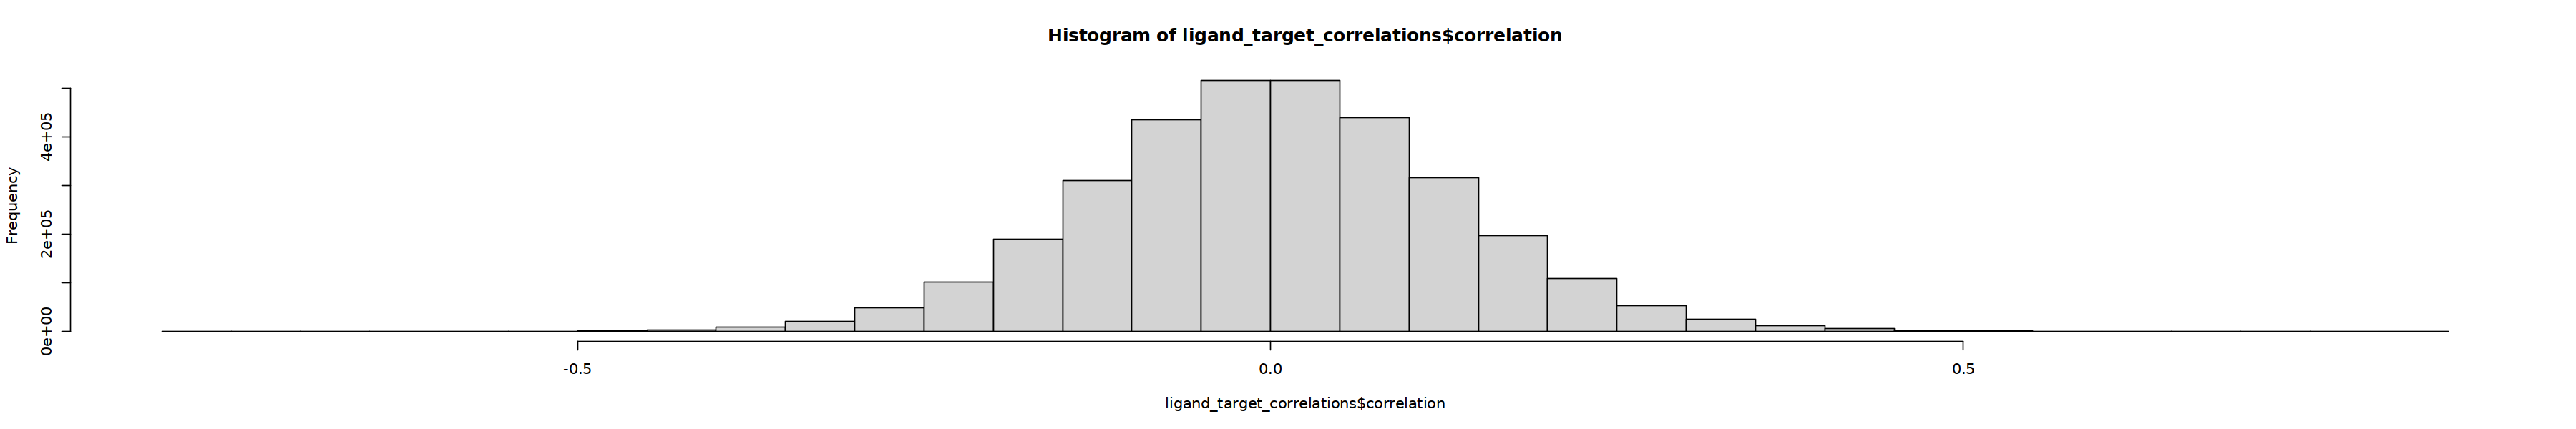

In [314]:
options(repr.plot.width=30, repr.plot.height=5)
hist(ligand_target_correlations$correlation)

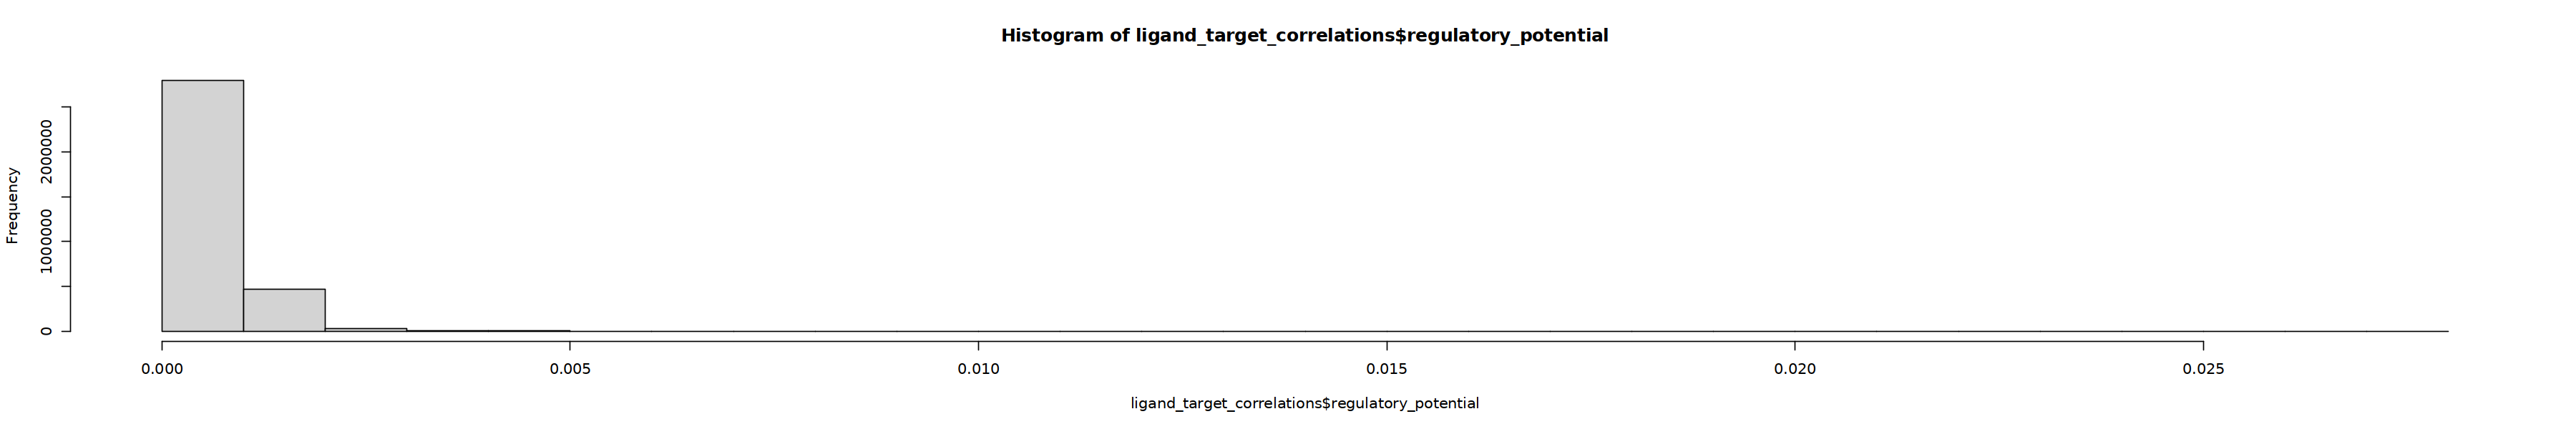

In [315]:
options(repr.plot.width=30, repr.plot.height=5)
hist(ligand_target_correlations$regulatory_potential)

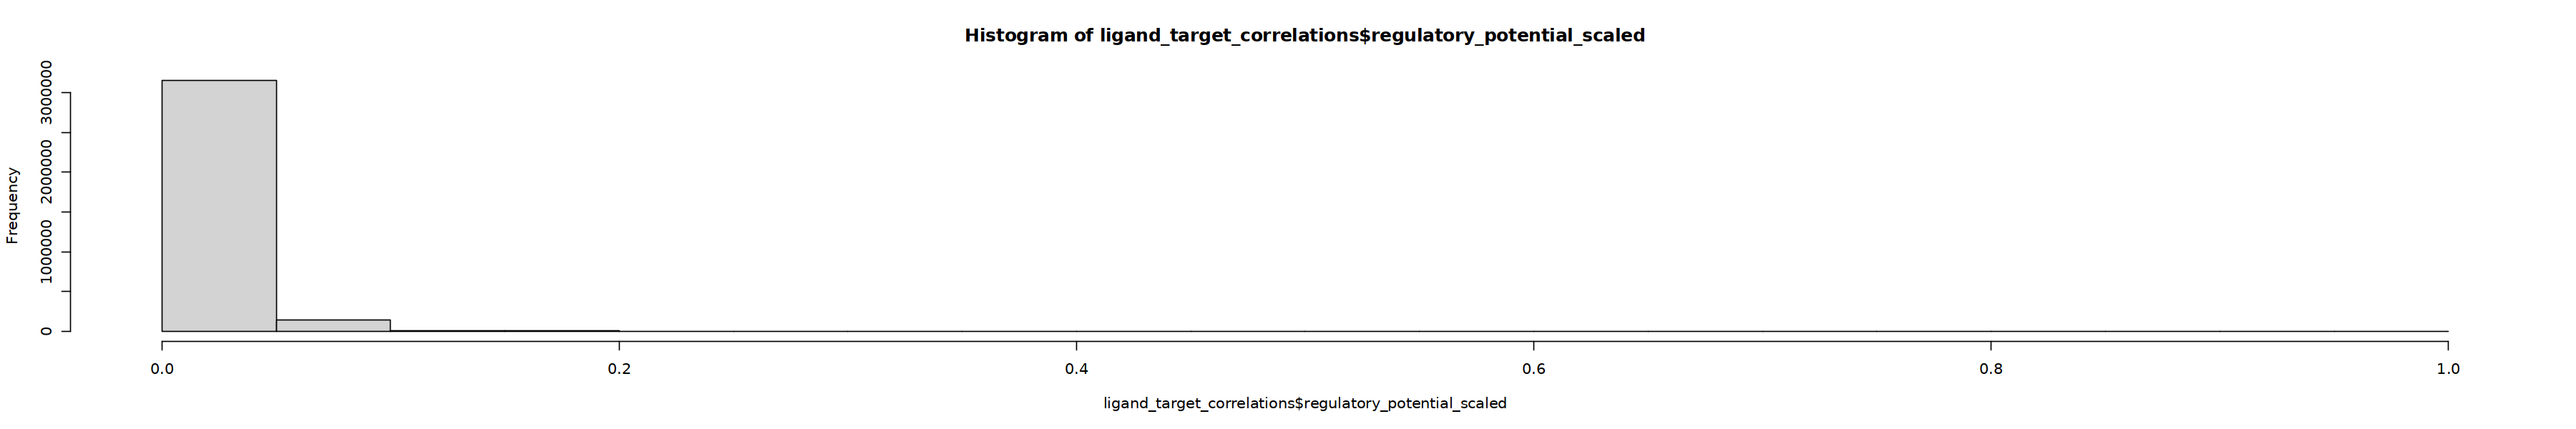

In [316]:
options(repr.plot.width=30, repr.plot.height=5)
hist(ligand_target_correlations$regulatory_potential_scaled)

In [317]:
sum(is.na(ligand_target_correlations))

[1] 1482

In [318]:
ligand_target_correlations[is.na(ligand_target_correlations)] = 0

## Adjustments to ligand-target correlations

In [319]:
### Remove cytokines that have been calculated as targets (because not included in ligand list above)

In [320]:
nrow(ligand_target_correlations)

[1] 3314320

In [321]:
ligand_target_correlations = ligand_target_correlations[ligand_target_correlations$Target_Type != 'cytokine',]

In [322]:
nrow(ligand_target_correlations)

[1] 3314320

In [323]:
### Only look at between cell-type communications --> remove same cell-type Links

In [324]:
ligand_target_correlations$Target_Cell_Type = str_replace(ligand_target_correlations$Target_Type, '.*_X\\d_|.*_X\\d\\d_','')

In [325]:
ligand_target_correlations$Ligand_Cell_Type = str_replace(ligand_target_correlations$Ligand_Type, '.*_X\\d_|.*_X\\d\\d_','')

In [326]:
ligand_target_correlations = ligand_target_correlations[ligand_target_correlations$Target_Cell_Type != ligand_target_correlations$Ligand_Cell_Type,]

In [327]:
nrow(ligand_target_correlations)

[1] 2721225

In [328]:
unique(ligand_target_correlations$Target_Cell_Type)

[1] "proteomics"              "Monocytes...CD16_FCGR3A"
 [3] "NK"                      "T.cell.CD4"             
 [5] "T.cell.CD8"              "B.cell"                 
 [7] "neutrophil"              "Dendritic"              
 [9] "clinical_data"           "Monocytes...CD14"

In [329]:
unique(ligand_target_correlations$Target_Cell_Type)

[1] "proteomics"              "Monocytes...CD16_FCGR3A"
 [3] "NK"                      "T.cell.CD4"             
 [5] "T.cell.CD8"              "B.cell"                 
 [7] "neutrophil"              "Dendritic"              
 [9] "clinical_data"           "Monocytes...CD14"

## Generate Ligand Target data with fitting receptors matches

In [330]:
ligand_target_correlations_matched = ligand_target_correlations ## left over from previous implementation --> rename

In [331]:
nrow(ligand_target_correlations_matched)

[1] 2721225

In [332]:
head(ligand_target_correlations_matched,2)

,Ligand_Gene,Target_Gene,cluster,Ligand,Target,correlation,Target_Type,Ligand_Type,regulatory_potential,regulatory_potential_scaled,Target_Cell_Type,Ligand_Cell_Type
,<chr>,<chr>,<chr>,<fct>,<fct>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,ADAM17,A1BG,proteomics,single_cell_0_X6_Monocytes...CD14__ADAM17,proteomics_0_A1BG_M0R009,-0.1841739,proteomics,single_cell_0_X6_Monocytes...CD14,0.0004622894,0.01667641,proteomics,Monocytes...CD14
2,ADAM17,A1BG,proteomics,single_cell_0_X4_Monocytes...CD14__ADAM17,proteomics_0_A1BG_M0R009,-0.1387664,proteomics,single_cell_0_X4_Monocytes...CD14,0.0004622894,0.01667641,proteomics,Monocytes...CD14


In [333]:
unique(ligand_target_correlations_matched[ligand_target_correlations_matched$Ligand_Gene == 'TGFB1',c('Ligand_Gene', 'Ligand_Type')])

,Ligand_Gene,Ligand_Type
,<chr>,<chr>
3019820,TGFB1,single_cell_0_X11_T.cell.CD4
3019821,TGFB1,neutrophil
3019822,TGFB1,single_cell_0_X12_Monocytes...CD16_FCGR3A
3019823,TGFB1,single_cell_0_X4_Monocytes...CD14
3019824,TGFB1,single_cell_0_X1_T.cell.CD8
3019825,TGFB1,single_cell_0_X7_Monocytes...CD14
3019827,TGFB1,single_cell_0_X3_NK
3019828,TGFB1,single_cell_0_X9_Monocytes...CD16_FCGR3A
3019829,TGFB1,single_cell_0_X6_Monocytes...CD14


In [334]:
cell_perc_cluster[cell_perc_cluster$gene == 'TGFB1',]

,X,perc_cells_expressing_gene,total_amount_cells_expressing_gene,gene,cluster
,<chr>,<dbl>,<int>,<chr>,<chr>
17949,TGFB1,24.86823,1840,TGFB1,X8_B.cell
37170,TGFB11,55.04175,1714,TGFB1,X9_Monocytes...CD16_FCGR3A
56391,TGFB12,22.52677,2819,TGFB1,X5_T.cell.CD4
75612,TGFB13,39.87745,9892,TGFB1,X0_T.cell.CD4
114054,TGFB15,56.33289,11128,TGFB1,X1_T.cell.CD8
133275,TGFB16,62.87270,7043,TGFB1,X6_Monocytes...CD14
152496,TGFB17,28.64034,5462,TGFB1,X2_T.cell.CD4
171717,TGFB18,74.81026,10941,TGFB1,X4_Monocytes...CD14
210159,TGFB110,51.28205,1420,TGFB1,X11_T.cell.CD4


In [335]:
name

[1] "V_FINAL"

In [336]:
write.table(ligand_target_correlations_matched,gzfile(paste0(result_path, '/F-Analysis/' ,'F4_Ligand_Target_Data', name, filter_samples,'.gz')))

In [337]:
#write.table(ligand_target_correlations_matched[ligand_target_correlations_matched$Target_Gene %in% c('PIM1', 'CD74', 'VCAN','UBC', 'PSME2', 'ODC1', 'PTMA', 'JUNB'),] ,gzfile(paste0(result_path, '/F-Analysis/' ,'F4_Ligand_Target_Data', name, filter_samples, 'filtered.gz')))

# Add Transcription Factors and complete pathway analysis (TBD)

In [338]:
head(ligand_target_correlations_matched,5)

,Ligand_Gene,Target_Gene,cluster,Ligand,Target,correlation,Target_Type,Ligand_Type,regulatory_potential,regulatory_potential_scaled,Target_Cell_Type,Ligand_Cell_Type
,<chr>,<chr>,<chr>,<fct>,<fct>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,ADAM17,A1BG,proteomics,single_cell_0_X6_Monocytes...CD14__ADAM17,proteomics_0_A1BG_M0R009,-0.184173885,proteomics,single_cell_0_X6_Monocytes...CD14,0.0004622894,0.01667641,proteomics,Monocytes...CD14
2,ADAM17,A1BG,proteomics,single_cell_0_X4_Monocytes...CD14__ADAM17,proteomics_0_A1BG_M0R009,-0.138766393,proteomics,single_cell_0_X4_Monocytes...CD14,0.0004622894,0.01667641,proteomics,Monocytes...CD14
3,ADAM17,A1BG,proteomics,single_cell_0_X6_Monocytes...CD14__ADAM17,proteomics_0_A1BG_P04217.2,-0.006539046,proteomics,single_cell_0_X6_Monocytes...CD14,0.0004622894,0.01667641,proteomics,Monocytes...CD14
4,ADAM17,A1BG,proteomics,single_cell_0_X4_Monocytes...CD14__ADAM17,proteomics_0_A1BG_P04217.2,0.050564953,proteomics,single_cell_0_X4_Monocytes...CD14,0.0004622894,0.01667641,proteomics,Monocytes...CD14
5,ADAM17,AAK1,X12_Monocytes...CD16_FCGR3A,single_cell_0_X4_Monocytes...CD14__ADAM17,single_cell_0_X12_Monocytes...CD16_FCGR3A__AAK1,-0.046869214,single_cell_0_X12_Monocytes...CD16_FCGR3A,single_cell_0_X4_Monocytes...CD14,0.0006336137,0.02285668,Monocytes...CD16_FCGR3A,Monocytes...CD14


In [339]:
head(up_features)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'head': object 'up_features' not found


In [ ]:
### Look only on selected target genes (Top MOFA features)

In [ ]:
ligand_target_correlations_filtered = ligand_target_correlations_matched[ligand_target_correlations_matched$Target %in% c(up_features, down_features),]

In [ ]:
unique(ligand_target_correlations_filtered$Ligand_Type)

In [ ]:
length(unique(ligand_target_correlations_filtered$Target)) # amont of target genes

In [ ]:
### Look only on a selected cell type as target

In [ ]:
unique(ligand_target_correlations_filtered$Target_Type)

In [ ]:
target_cluster = 'single_cell_0_X0_T.cell.CD4'

In [ ]:
ligand_target_correlations_filtered = ligand_target_correlations_filtered[ligand_target_correlations_filtered$Target_Type == target_cluster,]

In [ ]:
unique(ligand_target_correlations_filtered$Ligand_Type)

In [ ]:
### Summarize target genes of selected type

In [ ]:
targets = unique(ligand_target_correlations_filtered$Target_Gene)

In [ ]:
length(targets)

In [ ]:
### Identify potential expressed transcription factors

In [ ]:
amount_tfs = 4

In [ ]:
gene_regulatory_network = weighted_networks$gr

In [ ]:
head(gene_regulatory_network,2)

In [ ]:
length(unique(gene_regulatory_network$from))

In [ ]:
### Only consider transcription factors that might regulate one of the selected targets

In [ ]:
nrow(gene_regulatory_network)

In [ ]:
gene_regulatory_network = gene_regulatory_network[gene_regulatory_network$to %in% targets,]

In [ ]:
length(unique(gene_regulatory_network$from))

In [ ]:
transcription_factors = unique(weighted_networks$gr$from)

In [ ]:
nrow(gene_regulatory_network)

In [ ]:
options(repr.plot.width=30, repr.plot.height=5)
hist(gene_regulatory_network$weight)

In [ ]:
### Transcription factors need to be expressed in cell-type?   - TBD!

In [ ]:
#head(data_long,2)

In [ ]:
head(data_long)

In [ ]:
data_long$cluster = paste0(data_long$type, '_0_', str_replace(data_long$variable, '__.*', ''))

In [ ]:
data_long$cluster[data_long$type != 'single_cell'] = data_long$type[data_long$type != 'single_cell']

In [ ]:
unique(data_long$cluster)

In [ ]:
target_cluster

In [ ]:
unique(data_long$type)

In [ ]:
expressed_genes = data_long[data_long$cluster == target_cluster,]  %>% group_by(type, variable, ident) %>% summarise(mean_expr = mean(value, na.rm = TRUE), var_expression = var(value, na.rm = TRUE))

In [ ]:
expressed_genes$gene = str_replace(expressed_genes$variable, '.*__', '')

In [ ]:
head(expressed_genes,2)

In [ ]:
nrow(expressed_genes)

In [ ]:
length(unique(expressed_genes$gene))

In [ ]:
head(gene_regulatory_network,2)

In [ ]:
nrow(gene_regulatory_network)

In [ ]:
gene_regulatory_network = merge(gene_regulatory_network, expressed_genes, by.x = c('from'), by.y = c('gene'))

In [ ]:
nrow(gene_regulatory_network)

In [ ]:
head(gene_regulatory_network,2)

In [ ]:
gene_regulatory_network = gene_regulatory_network[,c('from', 'to', 'weight', 'mean_expr')]

In [ ]:
options(repr.plot.width=30, repr.plot.height=5)
hist(gene_regulatory_network$weight)

In [ ]:
#### Filter on which transcription factors to take for ligand target combination (based on ligand- tf scores and tf-target scores)

In [ ]:
colnames(gene_regulatory_network) = c('tf', 'target_gene', 'tf_target_weight', 'mean_expr')

In [ ]:
nrow(gene_regulatory_network)

In [ ]:
head(gene_regulatory_network)

In [ ]:
ligand_tf_scores = melt(ligand_tf_matrix)

In [ ]:
colnames(ligand_tf_scores) = c('tf', 'ligand', 'ligand_tf_score')

In [ ]:
head(ligand_tf_scores)

In [ ]:
length(unique(ligand_tf_scores$ligand))

In [ ]:
gene_regulatory_network = merge(gene_regulatory_network, ligand_tf_scores)

In [ ]:
nrow(gene_regulatory_network)

In [ ]:
head(gene_regulatory_network,2)

In [ ]:
### Combine both scores

In [ ]:
gene_regulatory_network$combined_score = gene_regulatory_network$tf_target_weight * gene_regulatory_network$ligand_tf_score

In [ ]:
options(repr.plot.width=30, repr.plot.height=5)
hist(gene_regulatory_network$combined_score)

In [ ]:
### Select top transcription factors per ligand, target combination

In [ ]:
top_tfs = gene_regulatory_network %>% group_by(ligand, target_gene) %>% top_n(amount_tfs, combined_score)

In [ ]:
nrow(top_tfs)

In [ ]:
head(top_tfs)

In [ ]:
options(repr.plot.width=30, repr.plot.height=5)
hist(top_tfs$combined_score)

In [ ]:
#top_tfs[top_tfs$tf == 'HMGB2',]

In [ ]:
#### Filter ligand target correlations on highest correlation and potential

In [ ]:
head(ligand_target_correlations_filtered,2)

In [ ]:
nrow(ligand_target_correlations_filtered)

In [ ]:
ligand_target_correlations_filtered = head(ligand_target_correlations_filtered[order(abs(ligand_target_correlations_filtered$cor_pot_combined), decreasing = TRUE),], 100)

In [ ]:
nrow(ligand_target_correlations_filtered)   # afterwards - multiple potential TFS mapped to ligand targets

In [ ]:
### Add potential transcription factors to ligand_target_correlations

In [ ]:
ligand_tf_targets = merge(ligand_target_correlations_filtered, top_tfs, by.x = c('Target_Gene', 'Ligand_Gene'), by.y = c('target_gene', 'ligand'))

In [ ]:
nrow(ligand_tf_targets)

In [ ]:
head(ligand_tf_targets,3)

In [ ]:
ligand_tf_targets$tf_id = paste0(ligand_tf_targets$Target_Type, '__', ligand_tf_targets$tf)

In [ ]:
##### Links

In [ ]:
ligand_tf_links = unique(ligand_tf_targets[,c('Ligand', 'tf_id', 'ligand_tf_score')])

In [ ]:
colnames(ligand_tf_links) = c('from', 'to', 'width')

In [ ]:
ligand_tf_links$width = ligand_tf_links$width/ (max(ligand_tf_links$width) - min(ligand_tf_links$width))

In [ ]:
ligand_tf_links$from = paste0(ligand_tf_links$from, '_', 'L')

In [ ]:
ligand_tf_links$to = paste0(ligand_tf_links$to, '_', 'TF')

In [ ]:
tf_target_links = unique(ligand_tf_targets[,c('tf_id', 'Target', 'tf_target_weight')])

In [ ]:
colnames(tf_target_links) = c('from', 'to', 'width')

In [ ]:
tf_target_links$width = tf_target_links$width/ (max(tf_target_links$width) - min(tf_target_links$width))

In [ ]:
tf_target_links$from = paste0(tf_target_links$from, '_', 'TF')

In [ ]:
tf_target_links$to = paste0(tf_target_links$to, '_', 'T')

In [ ]:
links = rbind( ligand_tf_links, tf_target_links)

In [ ]:
head(links,2)

In [ ]:
### Set threshold

In [ ]:
#### Filter ! -- minimum interaction score in order to display link and nodes
#links = links[links$width > 2,]

In [ ]:
#### Nodes

In [ ]:
ligand_nodes = unique(ligand_tf_targets[,c('Ligand', 'Ligand_Type')])

In [ ]:
colnames(ligand_nodes) = c('id', 'cluster')

In [ ]:
ligand_nodes$type = 'Ligand'

In [ ]:
ligand_nodes$id = paste0(ligand_nodes$id, '_', 'L')

In [ ]:
tf_nodes = unique(ligand_tf_targets[,c('tf_id', 'Target_Type')])

In [ ]:
colnames(tf_nodes) = c('id', 'cluster')

In [ ]:
tf_nodes$type = 'TF'

In [ ]:
tf_nodes$id = paste0(tf_nodes$id, '_', 'TF')

In [ ]:
target_nodes = unique(ligand_tf_targets[,c('Target', 'Target_Type')])

In [ ]:
colnames(target_nodes) = c('id', 'cluster')

In [ ]:
target_nodes$type = 'Target'

In [ ]:
target_nodes$id = paste0(target_nodes$id, '_', 'T')

In [ ]:
nodes = rbind(ligand_nodes, tf_nodes, target_nodes)

In [ ]:
head(nodes,2)

In [ ]:
nodes$cluster = str_replace(nodes$cluster, 'single_cell_0_', '')

In [ ]:
nodes$color[nodes$cluster == 'proteomics'] = '#2FE6EC'
nodes$color[nodes$cluster == 'cytokine'] = '#0E2D9F'
nodes$color[nodes$cluster == 'neutrophil'] = '#CA580E'
nodes$color[nodes$cluster %in%  c('X0_T.cell.CD4','X11_T.cell.CD4','X2_T.cell.CD4', 'X5_T.cell.CD4')  ] = '#E38DE5'
nodes$color[nodes$cluster %in%  c('X4_Monocytes...CD14','X6_Monocytes...CD14','X7_Monocytes...CD14')  ] = '#F1E984'
nodes$color[nodes$cluster %in%  c('X10_B.cell','X8_B.cell')  ] = '#8C75AD'
nodes$color[nodes$cluster %in%  c('X13_Dendritic')  ] = '#E6B17F'
nodes$color[nodes$cluster %in%  c('X1_T.cell.CD8')  ] = '#EC349B'
nodes$color[nodes$cluster %in%  c('X12_Monocytes...CD16_FCGR3A','X9_Monocytes...CD16_FCGR3A' )  ] = '#DCF39D'
nodes$color[nodes$cluster %in%  c('X3_NK' )  ] = '#9DB8F3'

In [ ]:
unique(nodes$color)

In [ ]:
nodes$shape = 'dot'

In [ ]:
nodes$shape[nodes$type == 'TF'] = 'triangle'

In [ ]:
nodes$shape[nodes$type == 'Target'] = 'square'

In [ ]:
head(nodes,2)

In [ ]:
length(unique(nodes$id))

In [ ]:
#nodes$type = TRUE

In [ ]:
#nodes$type[nodes$type == 'Receptor'] = FALSE

In [ ]:
nrow(nodes)

In [ ]:
nodes[nodes$id == 'single_cell_0_X0_T.cell.CD4__HMGB2',]

In [ ]:
#head(nodes)

In [ ]:
#### Plot Graph

In [ ]:
library('visNetwork')

In [ ]:
graph = visNetwork(nodes, links, width="100%", height="800px") %>%  visEdges(arrows = 'to') %>%
    visOptions(highlightNearest = list(enabled = TRUE, degree = 1, labelOnly = FALSE, hover = FALSE, algorithm = 'hierarchical', hideColor = '#0000FF00',labelOnly =TRUE  ), 
               #selectedBy = list(variable = "gene", selected = ligand,  style = 'width: 200px; height: 26px;
               #                  background: #ffffff;
               #                  color: darkblue;
               #                  border:none;
               #                  outline:none;', hideColor = '#0000FF00', highlight = TRUE, multiple = TRUE)
              ) %>%

               #nodesIdSelection = list(enabled = TRUE,
               #                  selected = "1",
               #                  style = 'width: 200px; height: 26px;
               #                  background: #ffffff;
               #                  color: darkblue;
               #                  border:none;
               #                  outline:none;')) %>%
    #visLayout(randomSeed = 123, improvedLayout = TRUE) %>% 
    #visPhysics(enabled =TRUE, stabilization = list(itearations = 100)) %>% 
    #visClusteringByGroup(groups = unique(nodes$group), label = 'Grouped: ', color = 'mediumaquamarine',  shape = 'triangle') %>%   # define which nodes should be collapsed
    #visLegend(addNodes = legend, width = 0.1, position = "right", main = "Type", useGroups = FALSE) %>% 
    visIgraphLayout(layout = 'layout_nicely')   #  'layout_with_lgl', #layout_with_fr #layout_nicely #layout_in_circle #layout_on_sphere #layout_as bipartite? #layout_as_tree

visSave(graph, paste0('figures/F_Ligand_Receptors/Ligand_TF_Target_Network_.html'), selfcontained = TRUE, background = "white")